In [1]:
from abc import ABC, abstractmethod
from sklearn.base import BaseEstimator


class BaseRegressor(BaseEstimator, ABC):
    """
    回归器的基类。

    这个类为我们的回归器提供了一个基础框架。
    它需要实现 `fit` 和 `predict` 方法，以及 `coef_` 属性。
    """

    @abstractmethod
    def fit(self, x, y=None):
        pass

    @abstractmethod
    def predict(self, x):
        pass

    @property
    @abstractmethod
    def coef_(self):
        pass

import numpy as np
from sklearn.utils.validation import check_is_fitted


class rEDMDc(BaseRegressor):
    """递归扩展动态模式分解含控制（rEDMDc）回归器。

    实现了含控制的 EDMD 的递归版本，当新数据可用时，递归更新系统矩阵 A 和 B，适用于时变系统。

    Attributes:
        state_matrix_ (numpy.ndarray):
            识别的系统状态转移矩阵 A。
        control_matrix_ (numpy.ndarray):
            识别的系统控制矩阵 B。
        Theta_hist_ (list):
            参数矩阵 Theta 的历史记录。
    """

    def __init__(self, n_states, n_controls, n_observables, lambda_reg=1.0, forgetting_factor=1.0):
        """初始化 rEDMDc 回归器。

        Args:
            n_states (int): 系统的状态数量。
            n_controls (int): 控制输入的数量。
            n_observables (int): 升维后的可观测量数量。
            lambda_reg (float): 初始协方差矩阵的正则化参数。
            forgetting_factor (float): 递归更新的遗忘因子（0 < lambda <= 1）。
        """
        self.n_states = n_states
        self.n_controls = n_controls
        self.n_observables = n_observables
        self.lambda_reg = lambda_reg
        self.forgetting_factor = forgetting_factor
        self.is_fitted_ = False

    def _initialize(self):
        """初始化递归矩阵。"""
        # 参数矩阵 Theta = [A | B]
        self.Theta_ = np.zeros((self.n_observables, self.n_observables + self.n_controls))
        # 逆协方差矩阵 P
        self.P_ = np.eye(self.n_observables + self.n_controls) / self.lambda_reg
        # 参数历史记录
        self.Theta_hist_ = []

    def _lift_state(self, x):
        """升维状态 x。

        在这里，我们使用二次多项式基函数。

        Args:
            x (numpy.ndarray): 状态向量。

        Returns:
            psi_x (numpy.ndarray): 升维后的状态向量。
        """
        x1, x2 = x.flatten()
        psi_x = np.array([x1, x2, x1**2, x1 * x2, x2**2])
        return psi_x.reshape(-1, 1)

    def fit(self, x, y=None, u=None):
        """拟合 rEDMDc 回归器到给定的数据。

        由于这是递归的，我们将顺序处理数据。

        Args:
            x (numpy.ndarray): 形状为 (n_samples, n_states) 的状态测量数据。
            y (numpy.ndarray, optional): 时间步长后的状态测量数据。默认为 None（未使用）。
            u (numpy.ndarray): 控制输入数据，形状为 (n_samples,) 或 (n_samples, 1)。
        """
        self._initialize()

        n_samples = x.shape[0]

        # 确保 u 是一维数组
        if u.ndim == 2 and u.shape[1] == 1:
            u = u.flatten()

        for k in range(n_samples - 1):
            x_k = x[k, :].reshape(-1, 1)
            x_k1 = x[k + 1, :].reshape(-1, 1)
            u_k = u[k]  # u_k 是标量

            # 升维状态
            psi_x_k = self._lift_state(x_k)
            psi_x_k1 = self._lift_state(x_k1)

            # 构建回归向量 phi_k = [psi_x_k; u_k]
            phi_k = np.vstack([psi_x_k, [[u_k]]])  # 将 u_k 转换为形状 (1, 1)

            # 预测误差：e_k = psi_x_k1 - Theta_ @ phi_k
            e_k = psi_x_k1 - self.Theta_ @ phi_k

            # 计算增益向量 K_k
            denominator = self.forgetting_factor + phi_k.T @ self.P_ @ phi_k
            K_k = (self.P_ @ phi_k) / denominator

            # 更新参数矩阵 Theta_
            self.Theta_ = self.Theta_ + e_k @ K_k.T

            # 记录参数历史
            self.Theta_hist_.append(self.Theta_.copy())

            # 更新逆协方差矩阵 P_
            self.P_ = (self.P_ - K_k @ phi_k.T @ self.P_) / self.forgetting_factor

        # 提取 A 和 B
        self.state_matrix_ = self.Theta_[:, :self.n_observables]
        self.control_matrix_ = self.Theta_[:, self.n_observables:]

        self.is_fitted_ = True
        return self

    def predict(self, x, u):
        """基于给定的数据预测下一时间步的状态。

        Args:
            x (numpy.ndarray): 形状为 (n_samples, n_states) 的状态测量数据。
            u (numpy.ndarray): 控制输入数据，形状为 (n_samples,) 或 (n_samples, 1)。

        Returns:
            y_pred (numpy.ndarray): 对 x 的下一时间步的预测。
        """
        check_is_fitted(self, "is_fitted_")
        n_samples = x.shape[0]
        y_pred = np.zeros((n_samples, self.n_states))

        # 确保 u 是一维数组
        if u.ndim == 2 and u.shape[1] == 1:
            u = u.flatten()

        for k in range(n_samples):
            x_k = x[k, :].reshape(-1, 1)
            u_k = u[k]  # u_k 是标量

            # 升维状态
            psi_x_k = self._lift_state(x_k)

            # 预测升维后的下一状态
            phi_k = np.vstack([psi_x_k, [[u_k]]])
            psi_x_k1 = self.Theta_ @ phi_k

            # 假设前 n_states 个可观测量对应于原始状态
            y_pred[k, :] = psi_x_k1[:self.n_states].flatten()

        return y_pred

    @property
    def coef_(self):
        """返回参数矩阵 Theta = [A | B]。"""
        check_is_fitted(self, "Theta_")
        return self.Theta_

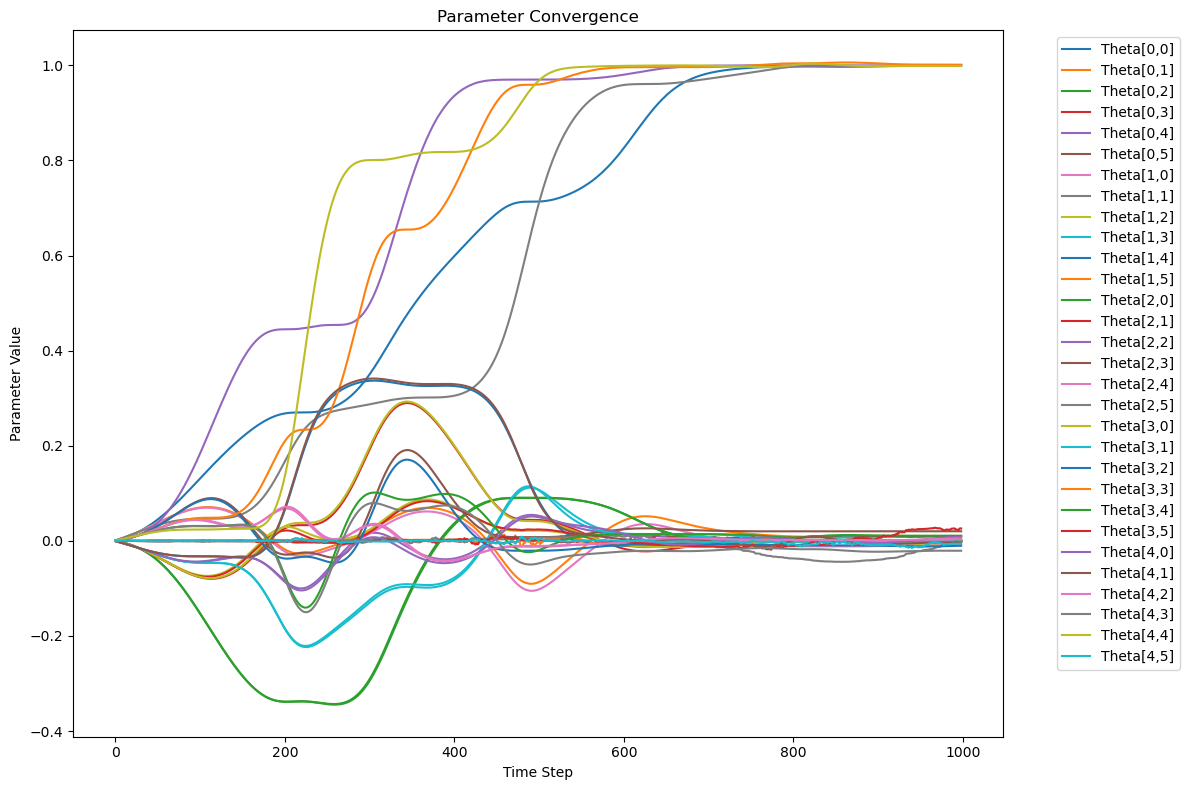

MAE: 0.0035067831669380947
MSE: 3.72152643892534e-05


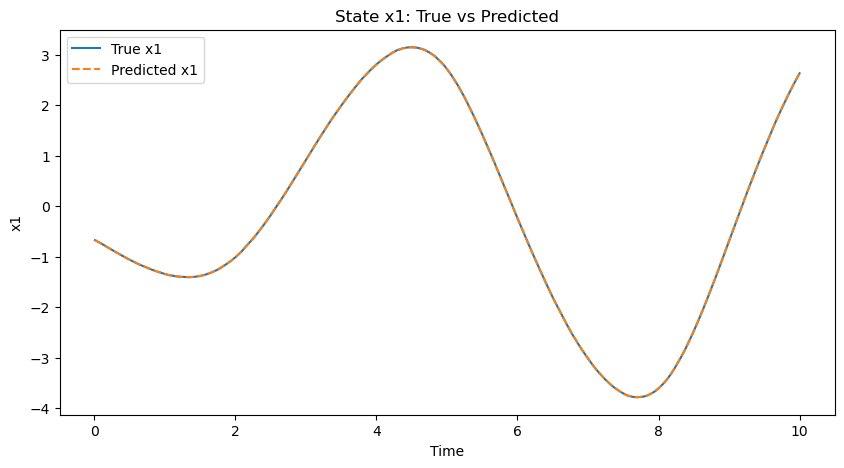

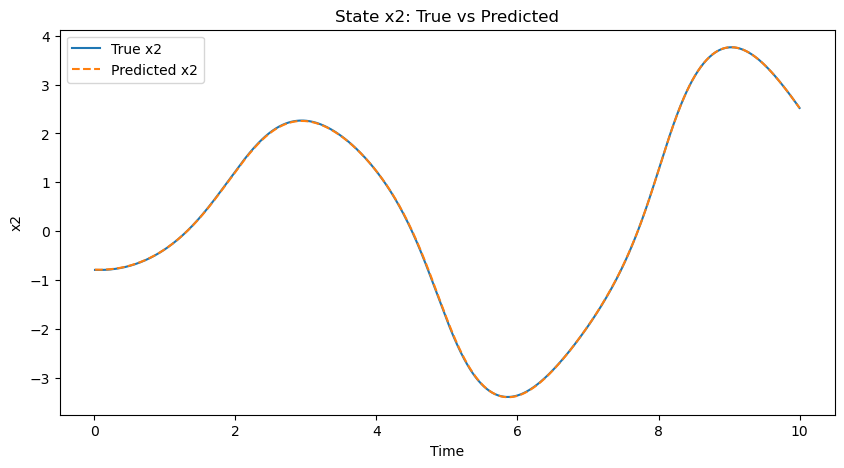

Recursive EDMDc computation time: 0.216600 seconds
Batch EDMDc computation time: 0.050496 seconds


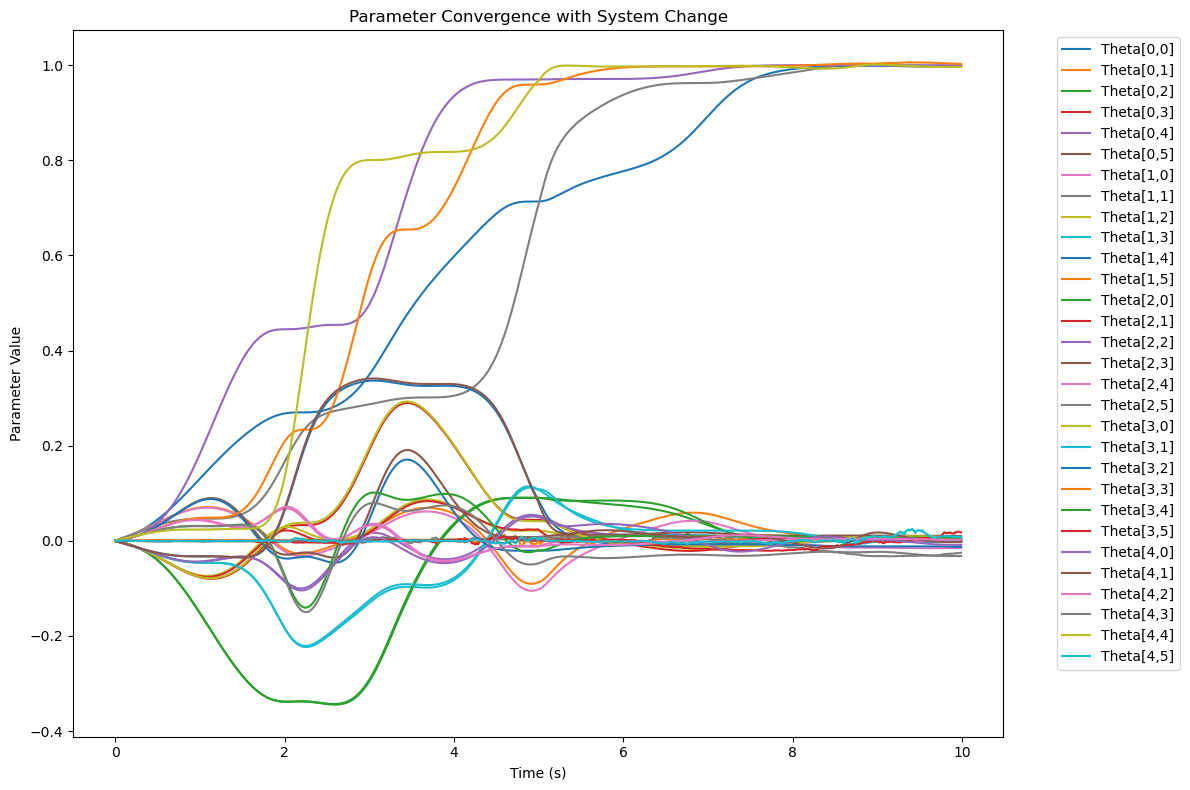

MAE: 0.007256189199391549
MSE: 0.00011211674896500149


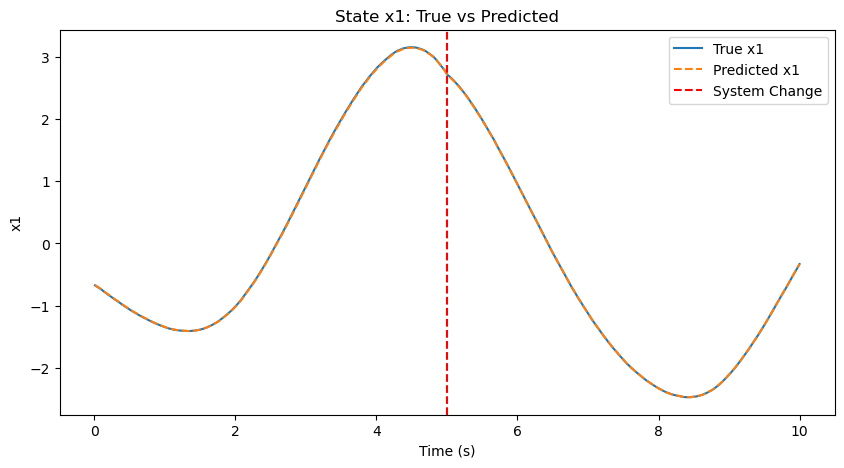

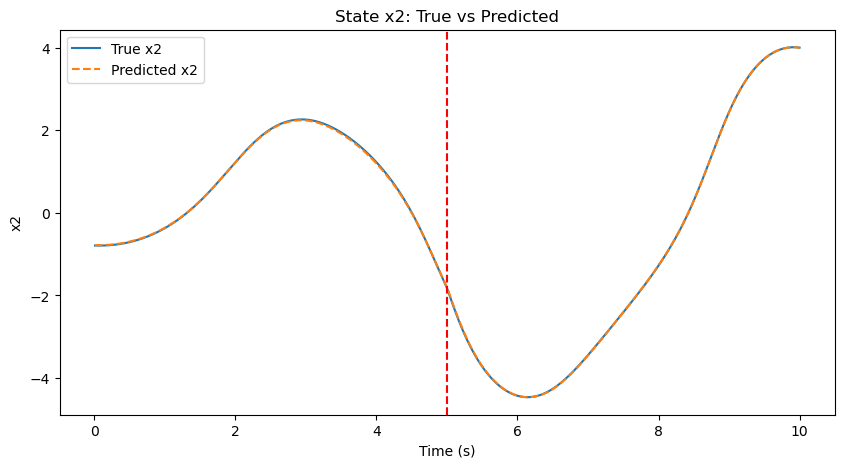

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_is_fitted

# 设置随机种子
np.random.seed(42)

# 定义时间参数
dt = 0.01  # 仿真时间步长
T = 10     # 总仿真时间
N = int(T / dt)  # 总时间步数

# 时间向量
time = np.linspace(0, T, N)

# 定义非线性系统的动力学
def system_dynamics(x, u):
    x1, x2 = x.flatten()
    dx1 = x2 + u
    dx2 = -x1 + np.sin(x2)
    dx = np.array([dx1, dx2]).reshape(-1, 1)
    return dx

# 生成数据集
x = np.zeros((N, 2))
# 将 u 定义为一维数组
u = np.random.normal(0, 0.1, size=N)

# 初始状态
x[0, :] = np.random.uniform(-1, 1, size=2)

# 数据生成循环
for k in range(N - 1):
    x_k = x[k, :].reshape(-1, 1)
    u_k = u[k]  # u_k 是标量
    dx = system_dynamics(x_k, u_k)
    x[k + 1, :] = (x_k + dx * dt).flatten()

# 定义升维函数
def lift_state(x):
    x1, x2 = x.flatten()
    psi_x = np.array([x1, x2, x1**2, x1 * x2, x2**2]).reshape(-1, 1)
    return psi_x

# 自定义 rEDMDc 类，使用新定义的升维函数
class CustomrEDMDc(rEDMDc):
    def _lift_state(self, x):
        return lift_state(x)
    
    def _initialize(self):
        super()._initialize()
        self.Theta_hist_ = []  # 参数历史记录

    def fit(self, x, y=None, u=None):
        self._initialize()

        n_samples = x.shape[0]

        # 确保 u 是一维数组
        if u.ndim == 2 and u.shape[1] == 1:
            u = u.flatten()

        for k in range(n_samples - 1):
            x_k = x[k, :].reshape(-1, 1)
            x_k1 = x[k + 1, :].reshape(-1, 1)
            u_k = u[k]  # u_k 是标量

            # 升维状态
            psi_x_k = self._lift_state(x_k)
            psi_x_k1 = self._lift_state(x_k1)

            # 构建回归向量 phi_k = [psi_x_k; u_k]
            phi_k = np.vstack([psi_x_k, [[u_k]]])  # 将 u_k 转换为形状 (1, 1)

            # 预测误差：e_k = psi_x_k1 - Theta_ @ phi_k
            e_k = psi_x_k1 - self.Theta_ @ phi_k

            # 计算增益向量 K_k
            denominator = self.forgetting_factor + phi_k.T @ self.P_ @ phi_k
            K_k = (self.P_ @ phi_k) / denominator

            # 更新参数矩阵 Theta_
            self.Theta_ = self.Theta_ + e_k @ K_k.T

            # 记录参数历史
            self.Theta_hist_.append(self.Theta_.copy())

            # 更新逆协方差矩阵 P_
            self.P_ = (self.P_ - K_k @ phi_k.T @ self.P_) / self.forgetting_factor

        # 提取 A 和 B
        self.state_matrix_ = self.Theta_[:, :self.n_observables]
        self.control_matrix_ = self.Theta_[:, self.n_observables:]

        self.is_fitted_ = True
        return self

    def predict(self, x, u):
        check_is_fitted(self, "is_fitted_")
        n_samples = x.shape[0]
        y_pred = np.zeros((n_samples, self.n_states))

        # 确保 u 是一维数组
        if u.ndim == 2 and u.shape[1] == 1:
            u = u.flatten()

        for k in range(n_samples):
            x_k = x[k, :].reshape(-1, 1)
            u_k = u[k]  # u_k 是标量

            # 升维状态
            psi_x_k = self._lift_state(x_k)

            # 预测升维后的下一状态
            phi_k = np.vstack([psi_x_k, [[u_k]]])
            psi_x_k1 = self.Theta_ @ phi_k

            # 假设前 n_states 个可观测量对应于原始状态
            y_pred[k, :] = psi_x_k1[:self.n_states].flatten()

        return y_pred

# 初始化模型
n_states = 2
n_controls = 1
n_observables = 5

model = CustomrEDMDc(
    n_states=n_states,
    n_controls=n_controls,
    n_observables=n_observables,
    lambda_reg=1000.0,      # 初始协方差矩阵的正则化参数
    forgetting_factor=0.99  # 遗忘因子
)

# 拟合模型
model.fit(x, u=u)

# 提取参数历史记录
Theta_hist = np.array(model.Theta_hist_)

# 绘制参数收敛性曲线
plt.figure(figsize=(12, 8))
for i in range(Theta_hist.shape[1]):
    for j in range(Theta_hist.shape[2]):
        parameter_values = Theta_hist[:, i, j]
        plt.plot(parameter_values, label=f'Theta[{i},{j}]')
plt.xlabel('Time Step')
plt.ylabel('Parameter Value')
plt.title('Parameter Convergence')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 使用模型进行单步预测
y_pred = model.predict(x[:-1, :], u=u[:-1])

# 计算 MAE 和 MSE
x_true = x[1:, :]
MAE = np.mean(np.abs(x_true - y_pred))
MSE = np.mean((x_true - y_pred)**2)

print(f'MAE: {MAE}')
print(f'MSE: {MSE}')

# 绘制真实值和预测值的比较
plt.figure(figsize=(10, 5))
plt.plot(time[1:], x_true[:, 0], label='True x1')
plt.plot(time[1:], y_pred[:, 0], '--', label='Predicted x1')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title('State x1: True vs Predicted')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time[1:], x_true[:, 1], label='True x2')
plt.plot(time[1:], y_pred[:, 1], '--', label='Predicted x2')
plt.xlabel('Time')
plt.ylabel('x2')
plt.legend()
plt.title('State x2: True vs Predicted')
plt.show()

# 测试计算效率
import time

# 递归方法计算时间
start_time = time.time()
model.fit(x, u=u)
end_time = time.time()
recursive_time = end_time - start_time

print(f'Recursive EDMDc computation time: {recursive_time:.6f} seconds')

# 批处理方法
def batch_EDMDc(x, u):
    n_samples = x.shape[0] - 1
    Psi = np.zeros((n_samples, n_observables))
    Psi_prime = np.zeros((n_samples, n_observables))
    U = u[:-1].reshape(-1, 1)
    for k in range(n_samples):
        Psi[k, :] = lift_state(x[k, :]).flatten()
        Psi_prime[k, :] = lift_state(x[k + 1, :]).flatten()
    Phi = np.hstack([Psi, U])
    start_time = time.time()
    Theta = np.linalg.lstsq(Phi, Psi_prime, rcond=None)[0]
    end_time = time.time()
    batch_time = end_time - start_time
    return Theta, batch_time

# 批处理方法计算时间
Theta_batch, batch_time = batch_EDMDc(x, u)
print(f'Batch EDMDc computation time: {batch_time:.6f} seconds')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_is_fitted
import time
# 设置随机种子
np.random.seed(42)

# 定义时间参数
dt = 0.01
T = 10
N = int(T / dt)
time = np.linspace(0, T, N)

# 定义非线性系统的动力学函数，包含系统变化
def system_dynamics(x, u, system_change=False):
    x1, x2 = x.flatten()
    if not system_change:
        dx1 = x2 + u
        dx2 = -x1 + np.sin(x2)
    else:
        dx1 = 0.5 * x2 + u    # 改变参数
        dx2 = -1.5 * x1 + np.sin(x2)  # 改变参数
    dx = np.array([dx1, dx2]).reshape(-1, 1)
    return dx

# 生成数据集，包含系统变化
x = np.zeros((N, 2))
u = np.random.normal(0, 0.1, size=N)
x[0, :] = np.random.uniform(-1, 1, size=2)

for k in range(N - 1):
    x_k = x[k, :].reshape(-1, 1)
    u_k = u[k]
    if time[k] >= 5.0:
        dx = system_dynamics(x_k, u_k, system_change=True)
    else:
        dx = system_dynamics(x_k, u_k, system_change=False)
    x[k + 1, :] = (x_k + dx * dt).flatten()

# 定义升维函数
def lift_state(x):
    x1, x2 = x.flatten()
    psi_x = np.array([x1, x2, x1**2, x1 * x2, x2**2]).reshape(-1, 1)
    return psi_x

# 自定义 rEDMDc 类
class CustomrEDMDc(rEDMDc):
    def _lift_state(self, x):
        return lift_state(x)

# 初始化模型
n_states = 2
n_controls = 1
n_observables = 5

model = CustomrEDMDc(
    n_states=n_states,
    n_controls=n_controls,
    n_observables=n_observables,
    lambda_reg=1000.0,
    forgetting_factor=0.99
)

# 拟合模型
model.fit(x, u=u)

# 提取参数历史记录
Theta_hist = np.array(model.Theta_hist_)

# 绘制参数收敛性曲线
plt.figure(figsize=(12, 8))
for i in range(Theta_hist.shape[1]):
    for j in range(Theta_hist.shape[2]):
        parameter_values = Theta_hist[:, i, j]
        plt.plot(time[:-1], parameter_values, label=f'Theta[{i},{j}]')
plt.xlabel('Time (s)')
plt.ylabel('Parameter Value')
plt.title('Parameter Convergence with System Change')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 使用模型进行单步预测
y_pred = model.predict(x[:-1, :], u=u[:-1])

# 计算 MAE 和 MSE
x_true = x[1:, :]
MAE = np.mean(np.abs(x_true - y_pred))
MSE = np.mean((x_true - y_pred)**2)

print(f'MAE: {MAE}')
print(f'MSE: {MSE}')

# 绘制真实值和预测值的比较
plt.figure(figsize=(10, 5))
plt.plot(time[1:], x_true[:, 0], label='True x1')
plt.plot(time[1:], y_pred[:, 0], '--', label='Predicted x1')
plt.axvline(x=5, color='r', linestyle='--', label='System Change')
plt.xlabel('Time (s)')
plt.ylabel('x1')
plt.legend()
plt.title('State x1: True vs Predicted')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time[1:], x_true[:, 1], label='True x2')
plt.plot(time[1:], y_pred[:, 1], '--', label='Predicted x2')
plt.axvline(x=5, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('x2')
plt.legend()
plt.title('State x2: True vs Predicted')
plt.show()

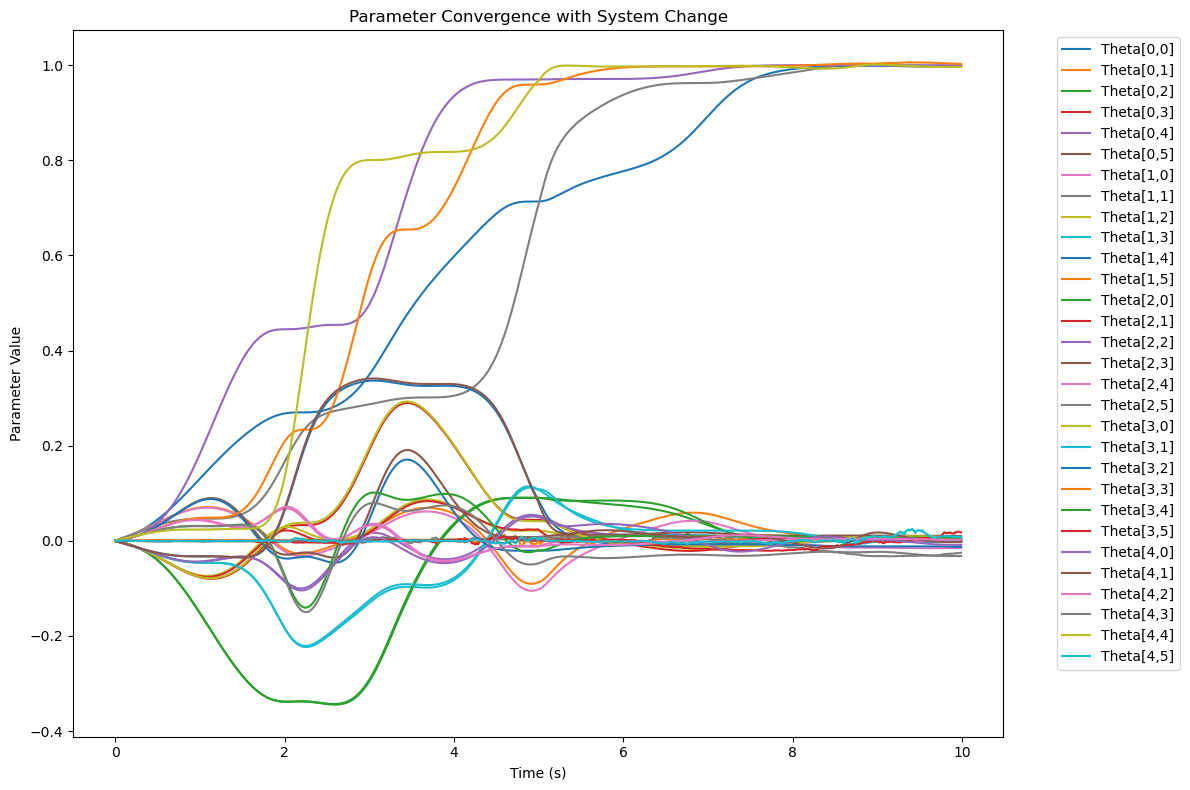

MAE: 0.007256189199391549
MSE: 0.00011211674896500149


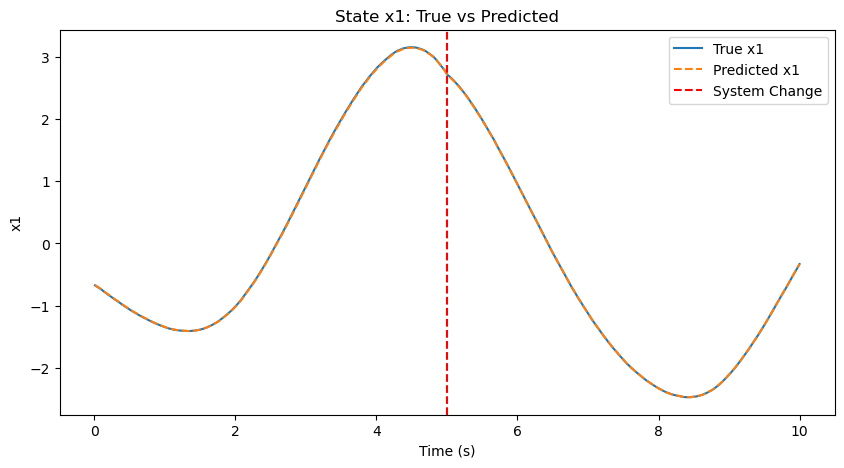

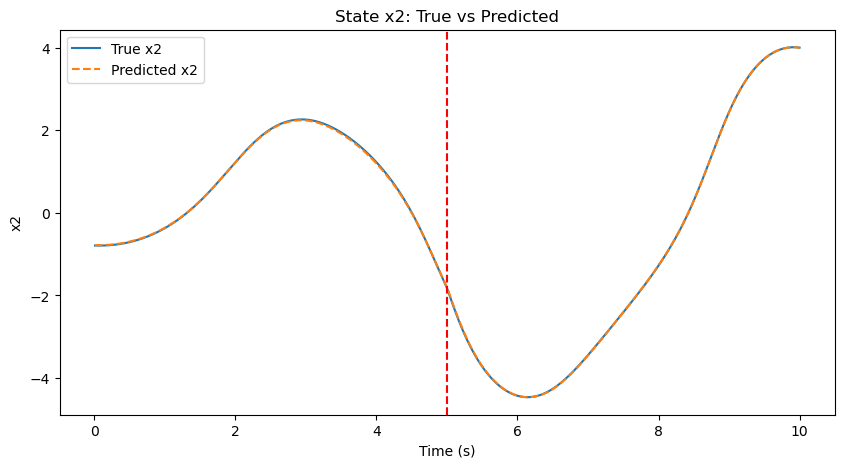

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_is_fitted
import time
# 设置随机种子
np.random.seed(42)

# 定义时间参数
dt = 0.01
T = 10
N = int(T / dt)
time = np.linspace(0, T, N)

# 定义非线性系统的动力学函数，包含系统变化
def system_dynamics(x, u, system_change=False):
    x1, x2 = x.flatten()
    if not system_change:
        dx1 = x2 + u
        dx2 = -x1 + np.sin(x2)
    else:
        dx1 = 0.5 * x2 + u    # 改变参数
        dx2 = -1.5 * x1 + np.sin(x2)  # 改变参数
    dx = np.array([dx1, dx2]).reshape(-1, 1)
    return dx

# 生成数据集，包含系统变化
x = np.zeros((N, 2))
u = np.random.normal(0, 0.1, size=N)
x[0, :] = np.random.uniform(-1, 1, size=2)

for k in range(N - 1):
    x_k = x[k, :].reshape(-1, 1)
    u_k = u[k]
    if time[k] >= 5.0:
        dx = system_dynamics(x_k, u_k, system_change=True)
    else:
        dx = system_dynamics(x_k, u_k, system_change=False)
    x[k + 1, :] = (x_k + dx * dt).flatten()

# 定义升维函数
def lift_state(x):
    x1, x2 = x.flatten()
    psi_x = np.array([x1, x2, x1**2, x1 * x2, x2**2]).reshape(-1, 1)
    return psi_x

# 自定义 rEDMDc 类
class CustomrEDMDc(rEDMDc):
    def _lift_state(self, x):
        return lift_state(x)

# 初始化模型
n_states = 2
n_controls = 1
n_observables = 5

model = CustomrEDMDc(
    n_states=n_states,
    n_controls=n_controls,
    n_observables=n_observables,
    lambda_reg=1000.0,
    forgetting_factor=0.99
)

# 拟合模型
model.fit(x, u=u)

# 提取参数历史记录
Theta_hist = np.array(model.Theta_hist_)

# 绘制参数收敛性曲线
plt.figure(figsize=(12, 8))
for i in range(Theta_hist.shape[1]):
    for j in range(Theta_hist.shape[2]):
        parameter_values = Theta_hist[:, i, j]
        plt.plot(time[:-1], parameter_values, label=f'Theta[{i},{j}]')
plt.xlabel('Time (s)')
plt.ylabel('Parameter Value')
plt.title('Parameter Convergence with System Change')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 使用模型进行单步预测
y_pred = model.predict(x[:-1, :], u=u[:-1])

# 计算 MAE 和 MSE
x_true = x[1:, :]
MAE = np.mean(np.abs(x_true - y_pred))
MSE = np.mean((x_true - y_pred)**2)

print(f'MAE: {MAE}')
print(f'MSE: {MSE}')

# 绘制真实值和预测值的比较
plt.figure(figsize=(10, 5))
plt.plot(time[1:], x_true[:, 0], label='True x1')
plt.plot(time[1:], y_pred[:, 0], '--', label='Predicted x1')
plt.axvline(x=5, color='r', linestyle='--', label='System Change')
plt.xlabel('Time (s)')
plt.ylabel('x1')
plt.legend()
plt.title('State x1: True vs Predicted')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time[1:], x_true[:, 1], label='True x2')
plt.plot(time[1:], y_pred[:, 1], '--', label='Predicted x2')
plt.axvline(x=5, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('x2')
plt.legend()
plt.title('State x2: True vs Predicted')
plt.show()

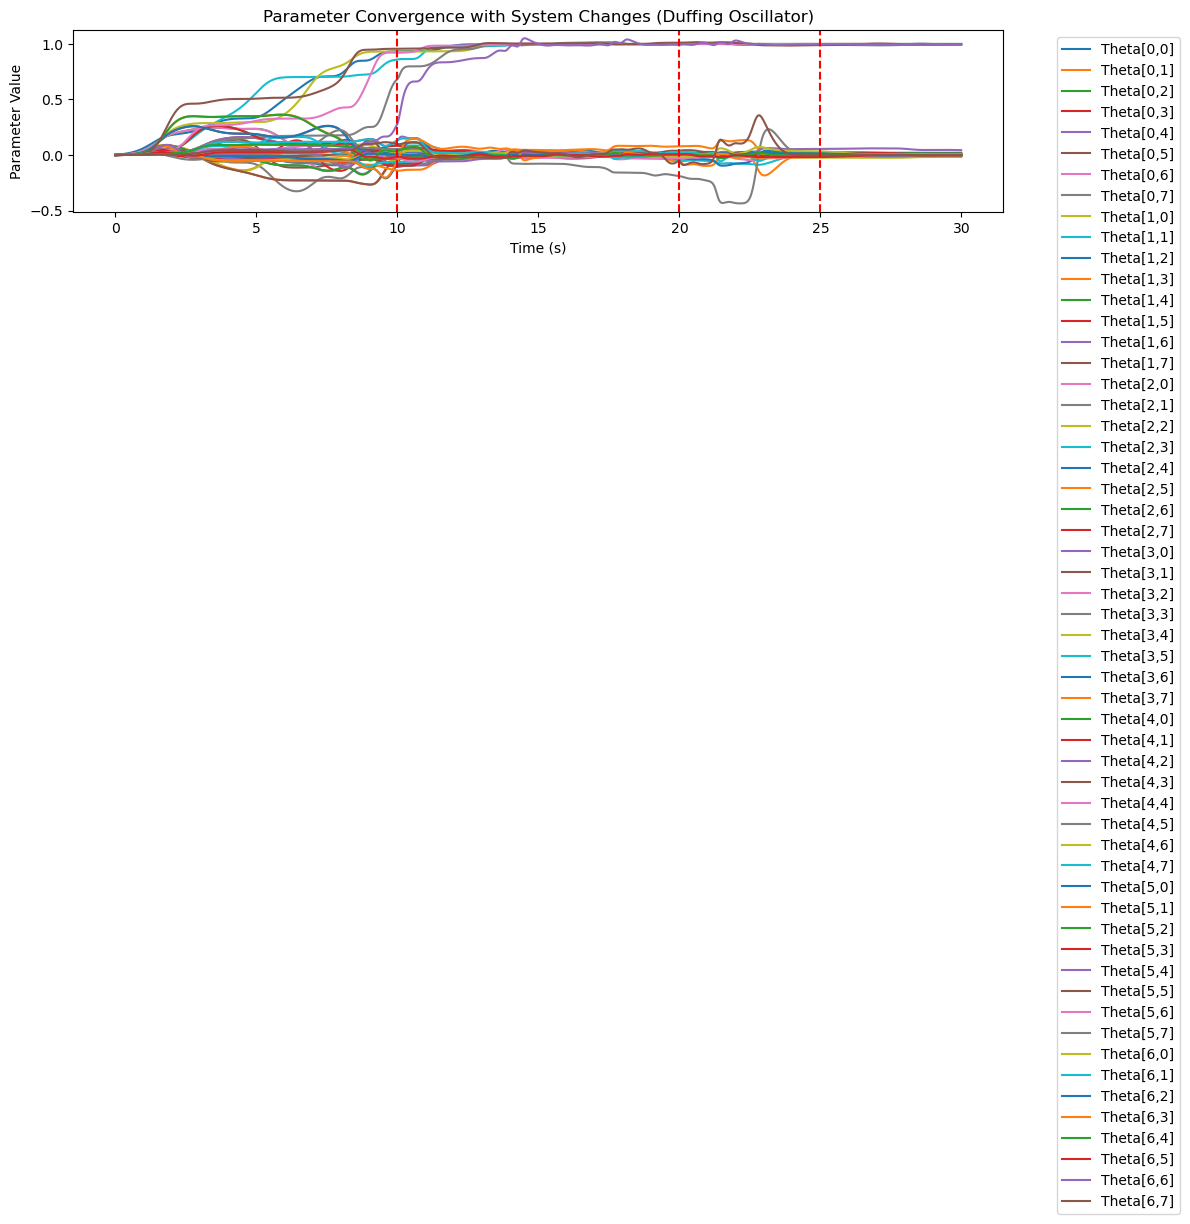

MAE: 0.001390329793383046
MSE: 9.262342694632038e-06


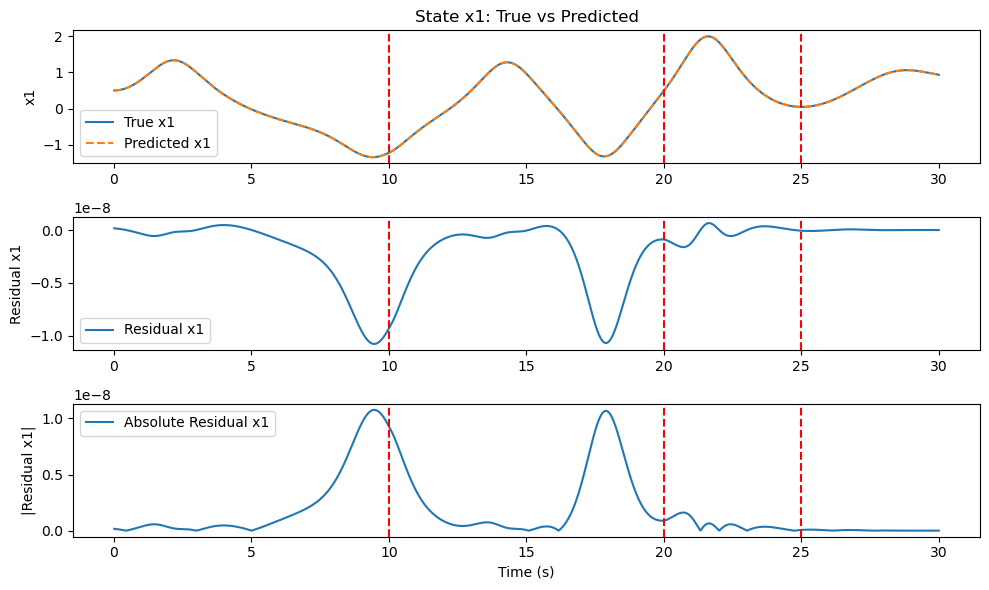

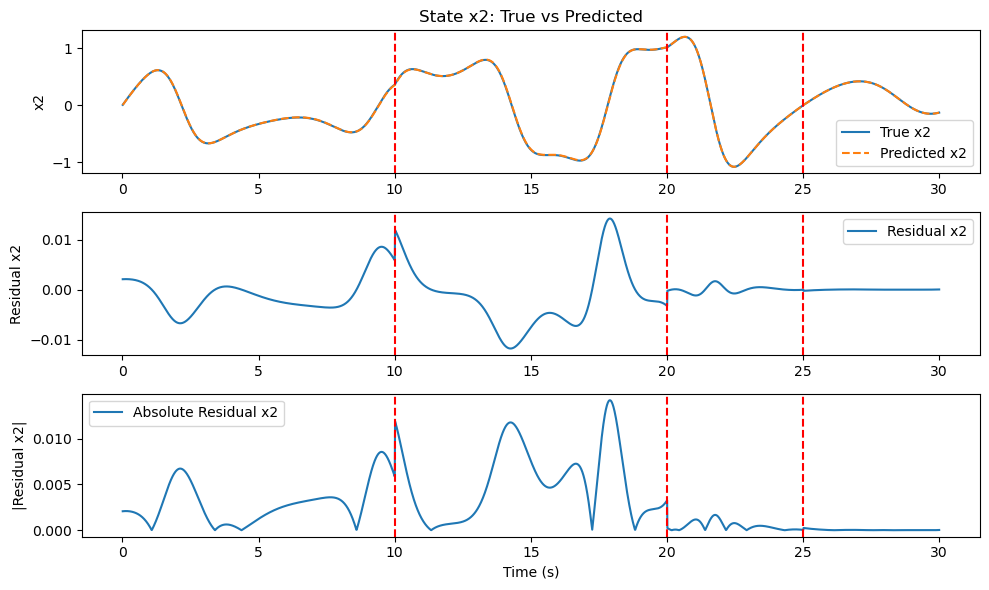

In [4]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_is_fitted
import time

# 基础回归器类（保持不变）
from abc import ABC, abstractmethod
from sklearn.base import BaseEstimator

class BaseRegressor(BaseEstimator, ABC):
    @abstractmethod
    def fit(self, x, y=None):
        pass

    @abstractmethod
    def predict(self, x):
        pass

    @property
    @abstractmethod
    def coef_(self):
        pass

# rEDMDc 类（保持不变）
class rEDMDc(BaseRegressor):
    # 类的定义，省略，与之前相同
    def __init__(self, n_states, n_controls, n_observables, lambda_reg=1.0, forgetting_factor=1.0):
        self.n_states = n_states
        self.n_controls = n_controls
        self.n_observables = n_observables
        self.lambda_reg = lambda_reg
        self.forgetting_factor = forgetting_factor
        self.is_fitted_ = False

    def _initialize(self):
        self.Theta_ = np.zeros((self.n_observables, self.n_observables + self.n_controls))
        self.P_ = np.eye(self.n_observables + self.n_controls) / self.lambda_reg
        self.Theta_hist_ = []

    def _lift_state(self, x):
        pass  # 在子类中实现

    def fit(self, x, y=None, u=None):
        self._initialize()
        n_samples = x.shape[0]
        if u.ndim == 2 and u.shape[1] == 1:
            u = u.flatten()
        for k in range(n_samples - 1):
            x_k = x[k, :].reshape(-1, 1)
            x_k1 = x[k + 1, :].reshape(-1, 1)
            u_k = u[k]
            psi_x_k = self._lift_state(x_k)
            psi_x_k1 = self._lift_state(x_k1)
            phi_k = np.vstack([psi_x_k, [[u_k]]])
            e_k = psi_x_k1 - self.Theta_ @ phi_k
            denominator = self.forgetting_factor + phi_k.T @ self.P_ @ phi_k
            K_k = (self.P_ @ phi_k) / denominator
            self.Theta_ = self.Theta_ + e_k @ K_k.T
            self.Theta_hist_.append(self.Theta_.copy())
            self.P_ = (self.P_ - K_k @ phi_k.T @ self.P_) / self.forgetting_factor
        self.state_matrix_ = self.Theta_[:, :self.n_observables]
        self.control_matrix_ = self.Theta_[:, self.n_observables:]
        self.is_fitted_ = True
        return self

    def predict(self, x, u):
        check_is_fitted(self, "is_fitted_")
        n_samples = x.shape[0]
        y_pred = np.zeros((n_samples, self.n_states))
        if u.ndim == 2 and u.shape[1] == 1:
            u = u.flatten()
        for k in range(n_samples):
            x_k = x[k, :].reshape(-1, 1)
            u_k = u[k]
            psi_x_k = self._lift_state(x_k)
            phi_k = np.vstack([psi_x_k, [[u_k]]])
            psi_x_k1 = self.Theta_ @ phi_k
            y_pred[k, :] = psi_x_k1[:self.n_states].flatten()
        return y_pred

    @property
    def coef_(self):
        check_is_fitted(self, "Theta_")
        return self.Theta_

# 设置随机种子
np.random.seed(42)

# 定义时间参数
dt = 0.01
T = 30
N = int(T / dt)
time = np.linspace(0, T, N)

# 定义 Duffing 振子的系统动力学函数
def duffing_system(x, u, delta, alpha, beta):
    x1, x2 = x.flatten()
    dx1 = x2
    dx2 = -delta * x2 - alpha * x1 - beta * x1**3 + u
    dx = np.array([dx1, dx2]).reshape(-1, 1)
    return dx

# 初始系统参数
delta_1, alpha_1, beta_1 = 0.2, -1.0, 1.0

# 系统变化后的参数
delta_2, alpha_2, beta_2 = 0.2, -0.5, 1.0
delta_3, alpha_3, beta_3 = 0.2, -1.0, 0.5
delta_4, alpha_4, beta_4 = 0.2, -0.5, 0.5

# 系统变化的时间点
change_times = [10.0, 20.0, 25.0]

# 控制输入（驱动力）
omega = 1.0
gamma = 0.3
u = gamma * np.cos(omega * time)

# 初始化状态数组
x = np.zeros((N, 2))
x[0, :] = [0.5, 0.0]

# 数据生成循环
for k in range(N - 1):
    x_k = x[k, :].reshape(-1, 1)
    u_k = u[k]
    t_k = time[k]
    if t_k < change_times[0]:
        delta, alpha, beta = delta_1, alpha_1, beta_1
    elif t_k < change_times[1]:
        delta, alpha, beta = delta_2, alpha_2, beta_2
    elif t_k < change_times[2]:
        delta, alpha, beta = delta_3, alpha_3, beta_3
    else:
        delta, alpha, beta = delta_4, alpha_4, beta_4
    dx = duffing_system(x_k, u_k, delta, alpha, beta)
    x[k + 1, :] = (x_k + dx * dt).flatten()

# 定义升维函数
def lift_state(x):
    x1, x2 = x.flatten()
    psi_x = np.array([x1, x2, x1**2, x2**2, x1*x2, x1**3, x2**3]).reshape(-1, 1)
    return psi_x

# 自定义 rEDMDc 类
class CustomrEDMDc(rEDMDc):
    def _lift_state(self, x):
        return lift_state(x)

# 初始化模型
n_states = 2
n_controls = 1
n_observables = 7

model = CustomrEDMDc(
    n_states=n_states,
    n_controls=n_controls,
    n_observables=n_observables,
    lambda_reg=1000.0,
    forgetting_factor=0.99
)

# 拟合模型
model.fit(x, u=u)

# 提取参数历史记录
Theta_hist = np.array(model.Theta_hist_)

# 绘制参数收敛性曲线
plt.figure(figsize=(12, 8))
for i in range(Theta_hist.shape[1]):
    for j in range(Theta_hist.shape[2]):
        parameter_values = Theta_hist[:, i, j]
        plt.plot(time[:-1], parameter_values, label=f'Theta[{i},{j}]')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Parameter Value')
plt.title('Parameter Convergence with System Changes (Duffing Oscillator)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 使用模型进行单步预测
y_pred = model.predict(x[:-1, :], u=u[:-1])

# 计算 MAE 和 MSE
x_true = x[1:, :]
MAE = np.mean(np.abs(x_true - y_pred))
MSE = np.mean((x_true - y_pred)**2)

print(f'MAE: {MAE}')
print(f'MSE: {MSE}')

# 计算残差
residuals = x_true - y_pred

# 绘制 x1 的真实值、预测值和残差
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(time[1:], x_true[:, 0], label='True x1')
plt.plot(time[1:], y_pred[:, 0], '--', label='Predicted x1')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.ylabel('x1')
plt.legend()
plt.title('State x1: True vs Predicted')

plt.subplot(3, 1, 2)
plt.plot(time[1:], residuals[:, 0], label='Residual x1')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.ylabel('Residual x1')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[1:], np.abs(residuals[:, 0]), label='Absolute Residual x1')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('|Residual x1|')
plt.legend()

plt.tight_layout()
plt.show()

# 绘制 x2 的真实值、预测值和残差
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(time[1:], x_true[:, 1], label='True x2')
plt.plot(time[1:], y_pred[:, 1], '--', label='Predicted x2')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.ylabel('x2')
plt.legend()
plt.title('State x2: True vs Predicted')

plt.subplot(3, 1, 2)
plt.plot(time[1:], residuals[:, 1], label='Residual x2')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.ylabel('Residual x2')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[1:], np.abs(residuals[:, 1]), label='Absolute Residual x2')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('|Residual x2|')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

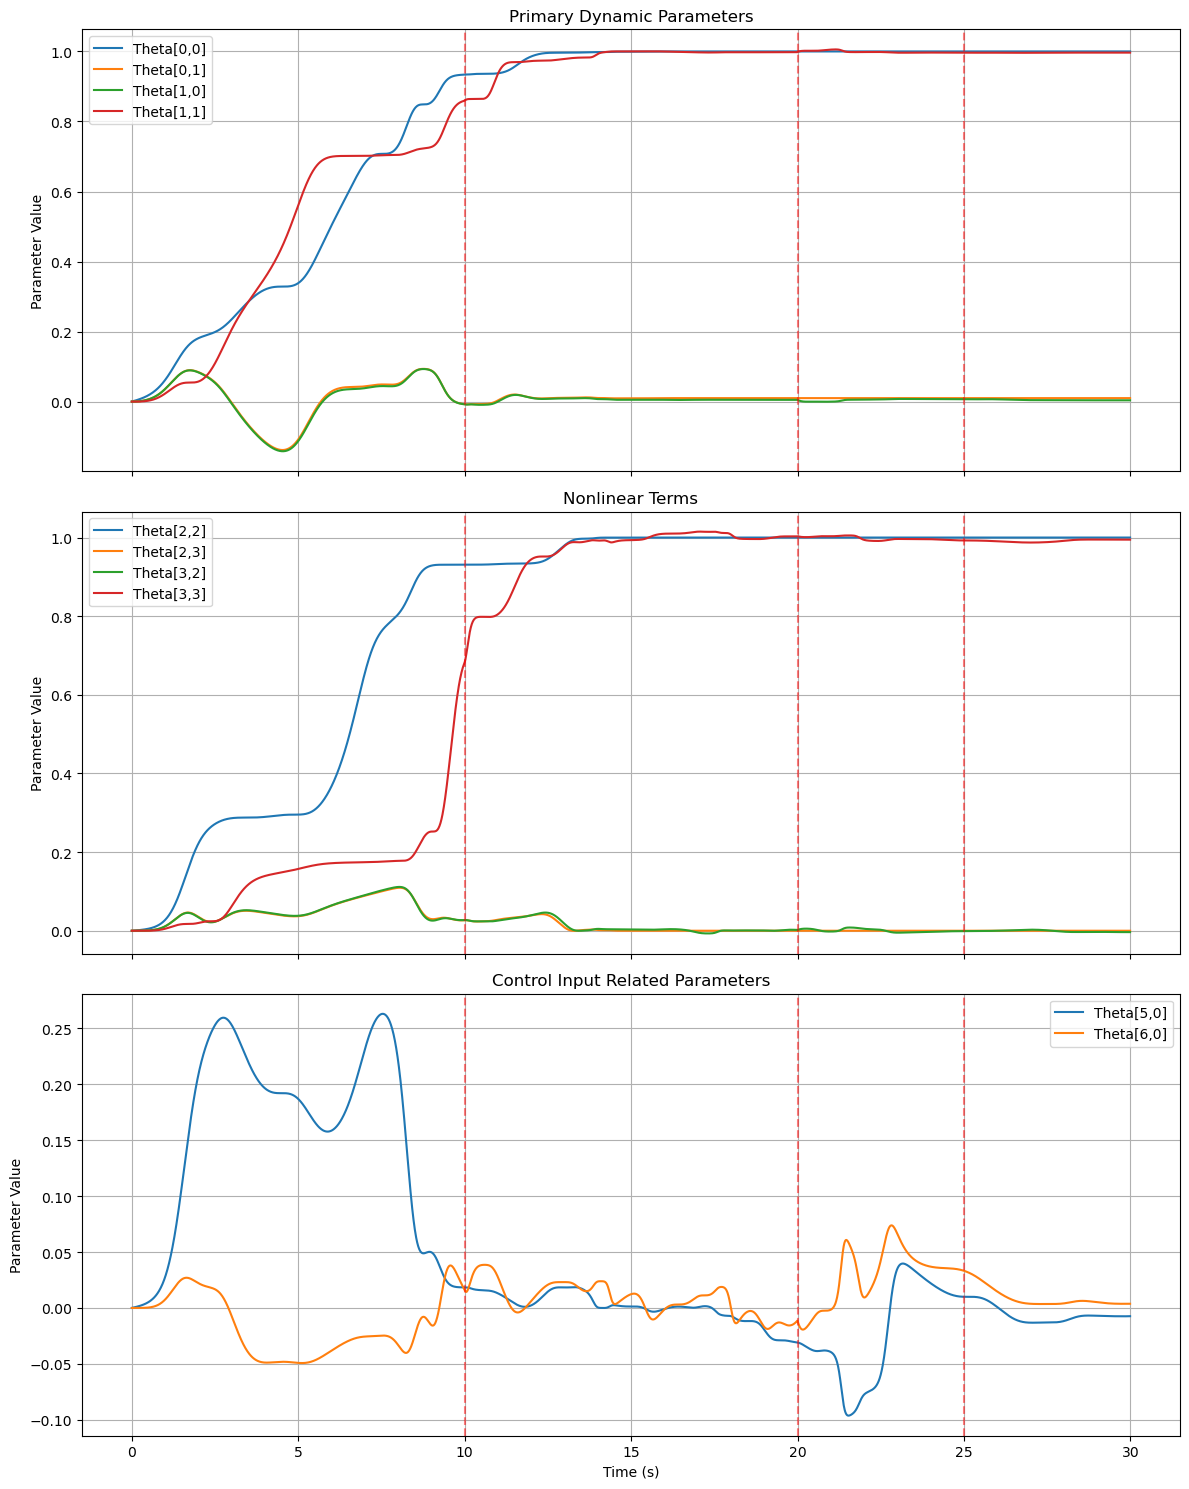

In [5]:
plt.figure(figsize=(15, 10))
# 创建子图
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# 按参数重要性或大小分组
# 第一组：主要动态参数
axs[0].set_title('Primary Dynamic Parameters')
for i, j in [(0,0), (0,1), (1,0), (1,1)]:
    axs[0].plot(time[:-1], Theta_hist[:, i, j], label=f'Theta[{i},{j}]')

# 第二组：非线性项参数
axs[1].set_title('Nonlinear Terms')
for i, j in [(2,2), (2,3), (3,2), (3,3)]:
    axs[1].plot(time[:-1], Theta_hist[:, i, j], label=f'Theta[{i},{j}]')

# 第三组：控制输入相关参数
axs[2].set_title('Control Input Related Parameters')
for i in range(5, Theta_hist.shape[1]):
    axs[2].plot(time[:-1], Theta_hist[:, i, 0], label=f'Theta[{i},0]')

# 在每个子图中添加系统变化的垂直线
for ax in axs:
    for t in change_times:
        ax.axvline(x=t, color='r', linestyle='--', alpha=0.5)
    ax.legend()
    ax.grid(True)

# 设置标签
axs[2].set_xlabel('Time (s)')
for ax in axs:
    ax.set_ylabel('Parameter Value')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

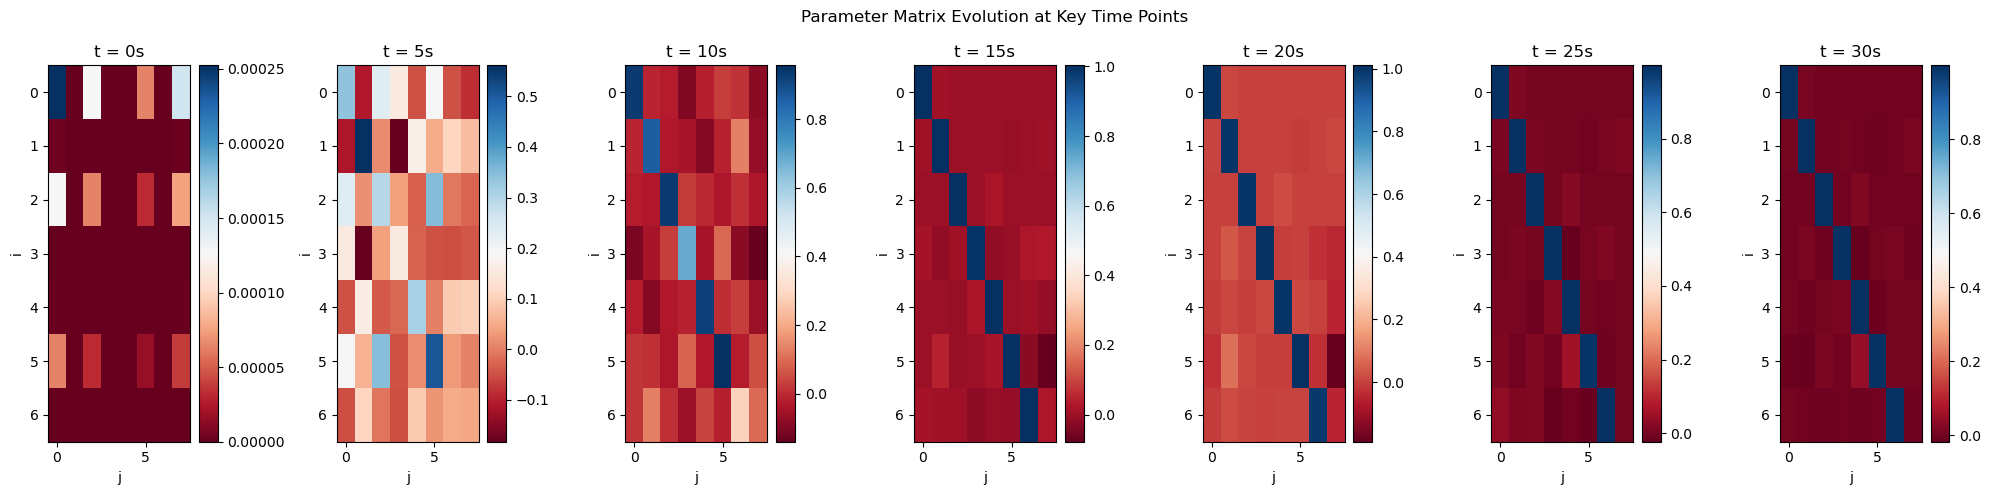

In [6]:
plt.figure(figsize=(12, 8))
# 选择特定时间点绘制热力图
time_points = [0, 5,10, 15,20, 25,30]  # 选择关键时间点
fig, axs = plt.subplots(1, len(time_points), figsize=(20, 5))

for i, t in enumerate(time_points):
    time_idx = np.argmin(np.abs(time[:-1] - t))
    im = axs[i].imshow(Theta_hist[time_idx], cmap='RdBu', aspect='auto')
    axs[i].set_title(f't = {t}s')
    plt.colorbar(im, ax=axs[i])
    axs[i].set_xlabel('j')
    axs[i].set_ylabel('i')

plt.suptitle('Parameter Matrix Evolution at Key Time Points')
plt.tight_layout()
plt.show()

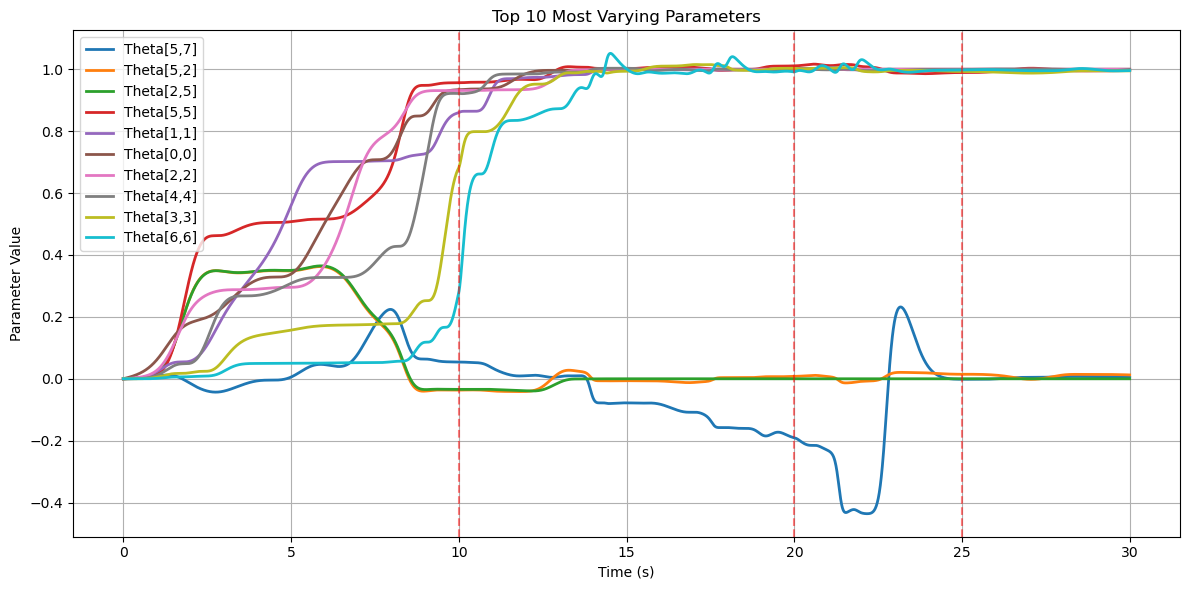

In [7]:
# 计算参数变化的标准差
param_std = np.std(Theta_hist, axis=0)
# 选择变化最大的前10个参数
top_n = 10
flat_idx = np.argsort(param_std.flatten())[-top_n:]
i_idx, j_idx = np.unravel_index(flat_idx, param_std.shape)

plt.figure(figsize=(12, 6))
for idx in range(top_n):
    i, j = i_idx[idx], j_idx[idx]
    plt.plot(time[:-1], Theta_hist[:, i, j], 
             label=f'Theta[{i},{j}]', linewidth=2)

for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--', alpha=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Parameter Value')
plt.title('Top 10 Most Varying Parameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

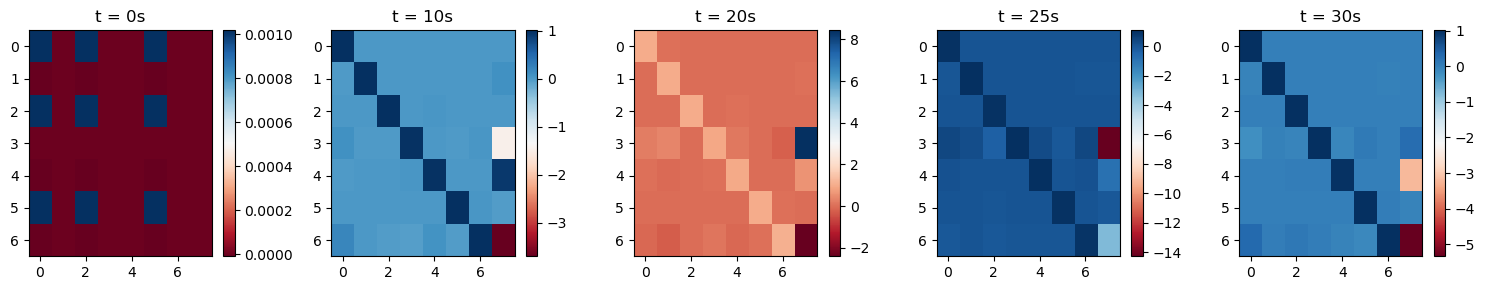

MAE: 0.0171065727042753
MSE: 0.0009505968917739407


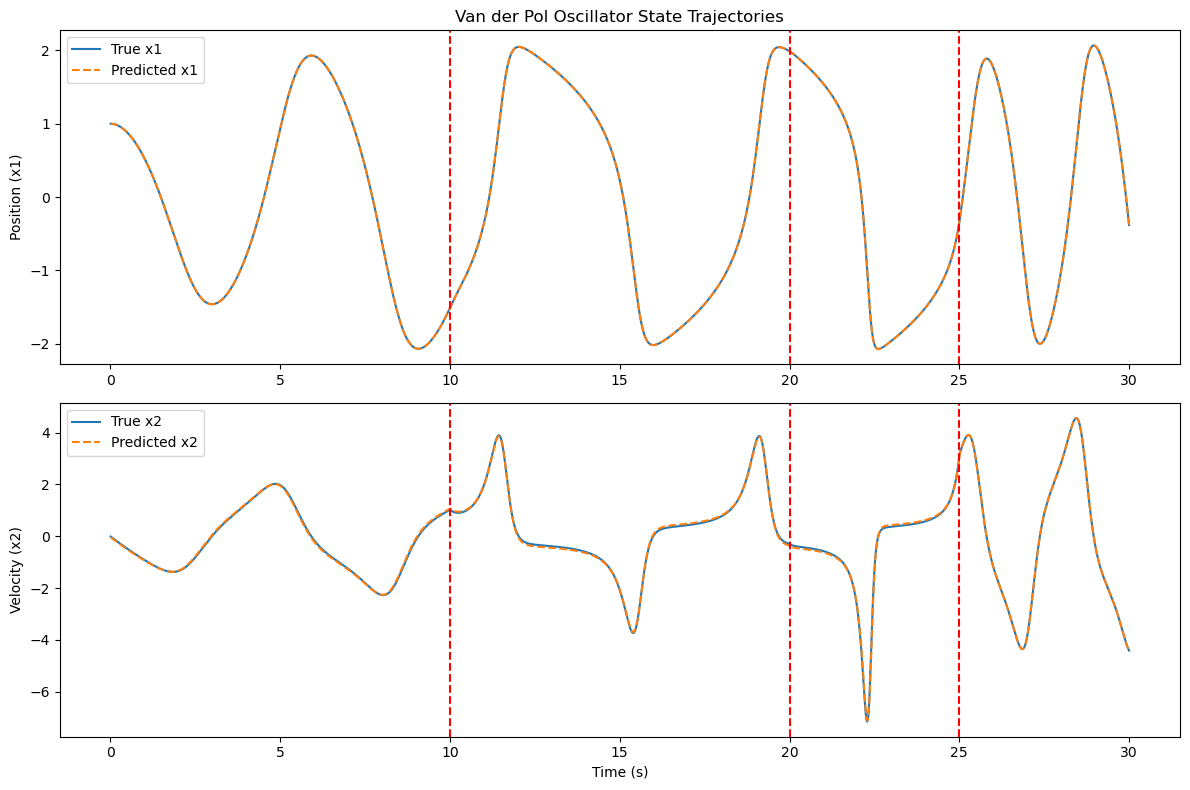

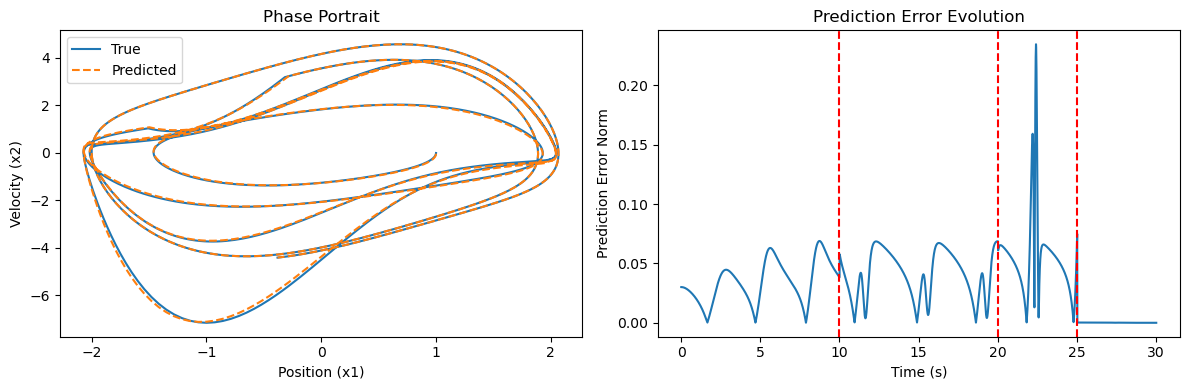

In [8]:
# 保持导入库和基类定义不变...

# 定义 Van der Pol 振子的系统动力学函数
def vanderpol_system(x, u, mu, omega):
    x1, x2 = x.flatten()
    dx1 = x2
    dx2 = mu * (1 - x1**2) * x2 - omega**2 * x1 + u
    dx = np.array([dx1, dx2]).reshape(-1, 1)
    return dx

# 设置时间参数
dt = 0.01
T = 30
N = int(T / dt)
time = np.linspace(0, T, N)

# 初始系统参数
mu_1, omega_1 = 0.5, 1.0  # 弱非线性区域

# 系统变化后的参数
mu_2, omega_2 = 2.0, 1.0  # 增强非线性
mu_3, omega_3 = 4.0, 1.5  # 强非线性，频率变化
mu_4, omega_4 = 1.0, 2.0  # 回到弱非线性，但频率更高

# 系统变化的时间点
change_times = [10.0, 20.0, 25.0]

# 控制输入（外部激励）
forcing_freq = 0.5
forcing_amp = 0.1
u = forcing_amp * np.sin(forcing_freq * time)

# 初始化状态数组
x = np.zeros((N, 2))
x[0, :] = [1.0, 0.0]  # 初始条件

# 数据生成循环
for k in range(N - 1):
    x_k = x[k, :].reshape(-1, 1)
    u_k = u[k]
    t_k = time[k]
    
    if t_k < change_times[0]:
        mu, omega = mu_1, omega_1
    elif t_k < change_times[1]:
        mu, omega = mu_2, omega_2
    elif t_k < change_times[2]:
        mu, omega = mu_3, omega_3
    else:
        mu, omega = mu_4, omega_4
        
    dx = vanderpol_system(x_k, u_k, mu, omega)
    x[k + 1, :] = (x_k + dx * dt).flatten()

# 定义升维函数
def lift_state(x):
    x1, x2 = x.flatten()
    # 为Van der Pol系统选择合适的基函数
    psi_x = np.array([
        x1,                  # 线性项
        x2,
        x1**2,              # 二次项
        x2**2,
        x1*x2,
        x1**3,              # 三次项
        x1**2*x2,           # 混合高阶项
    ]).reshape(-1, 1)
    return psi_x

# CustomrEDMDc类定义保持不变...

# 初始化模型
n_states = 2
n_controls = 1
n_observables = 7

model = CustomrEDMDc(
    n_states=n_states,
    n_controls=n_controls,
    n_observables=n_observables,
    lambda_reg=1000.0,
    forgetting_factor=0.98  # 稍微降低遗忘因子以更好地追踪参数变化
)

# 拟合模型并进行预测
model.fit(x, u=u)
Theta_hist = np.array(model.Theta_hist_)

# 绘制参数收敛性曲线（使用热力图方式）
time_points = [0, 10, 20, 25, 30]  # 关键时间点
plt.figure(figsize=(15, 3))
for i, t in enumerate(time_points):
    time_idx = np.argmin(np.abs(time[:-1] - t))
    plt.subplot(1, len(time_points), i+1)
    plt.imshow(Theta_hist[time_idx], cmap='RdBu', aspect='auto')
    plt.colorbar()
    plt.title(f't = {t}s')
plt.tight_layout()
plt.show()

# 使用模型进行预测
y_pred = model.predict(x[:-1, :], u=u[:-1])
x_true = x[1:, :]

# 计算性能指标
MAE = np.mean(np.abs(x_true - y_pred))
MSE = np.mean((x_true - y_pred)**2)
print(f'MAE: {MAE}')
print(f'MSE: {MSE}')

# 绘制状态轨迹和预测结果
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time[1:], x_true[:, 0], label='True x1')
plt.plot(time[1:], y_pred[:, 0], '--', label='Predicted x1')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.ylabel('Position (x1)')
plt.legend()
plt.title('Van der Pol Oscillator State Trajectories')

plt.subplot(2, 1, 2)
plt.plot(time[1:], x_true[:, 1], label='True x2')
plt.plot(time[1:], y_pred[:, 1], '--', label='Predicted x2')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (x2)')
plt.legend()

plt.tight_layout()
plt.show()

# 绘制相平面图
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_true[:, 0], x_true[:, 1], label='True')
plt.plot(y_pred[:, 0], y_pred[:, 1], '--', label='Predicted')
plt.xlabel('Position (x1)')
plt.ylabel('Velocity (x2)')
plt.title('Phase Portrait')
plt.legend()

# 绘制预测误差随时间的变化
plt.subplot(1, 2, 2)
error_norm = np.linalg.norm(x_true - y_pred, axis=1)
plt.plot(time[1:], error_norm)
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Prediction Error Norm')
plt.title('Prediction Error Evolution')

plt.tight_layout()
plt.show()

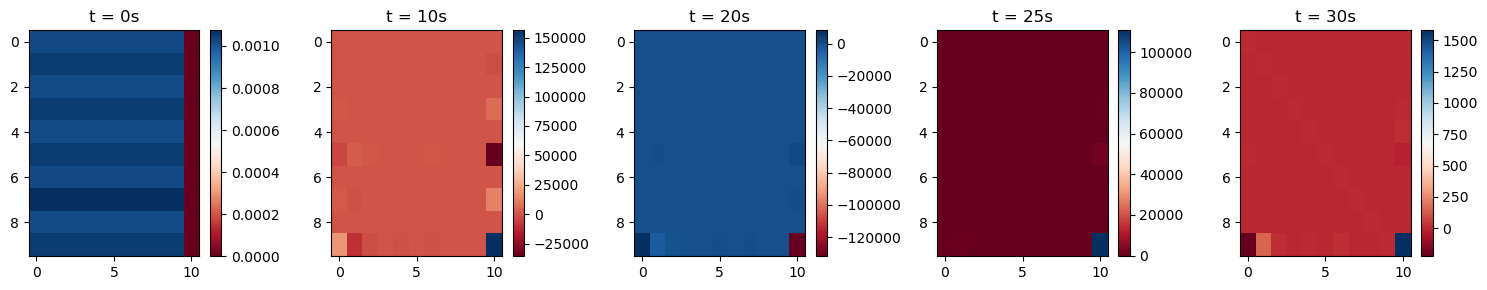

MAE: 0.009291737288249996
MSE: 0.0004934203248958171


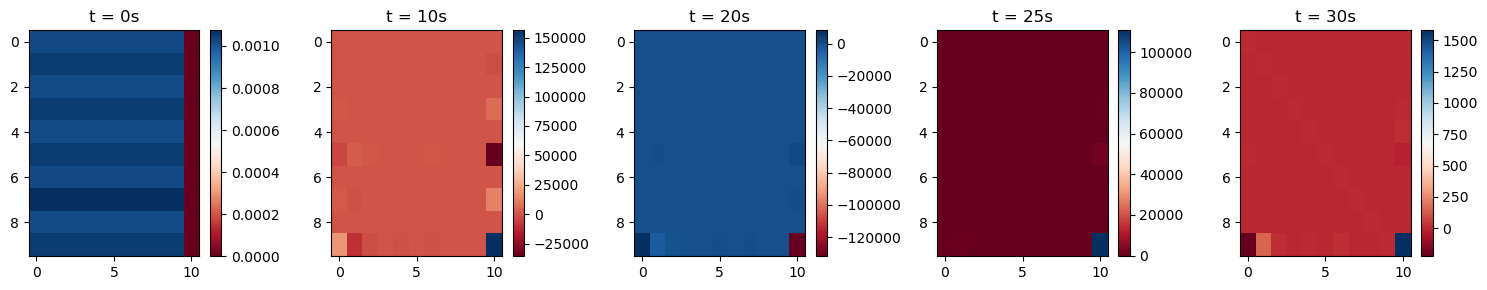

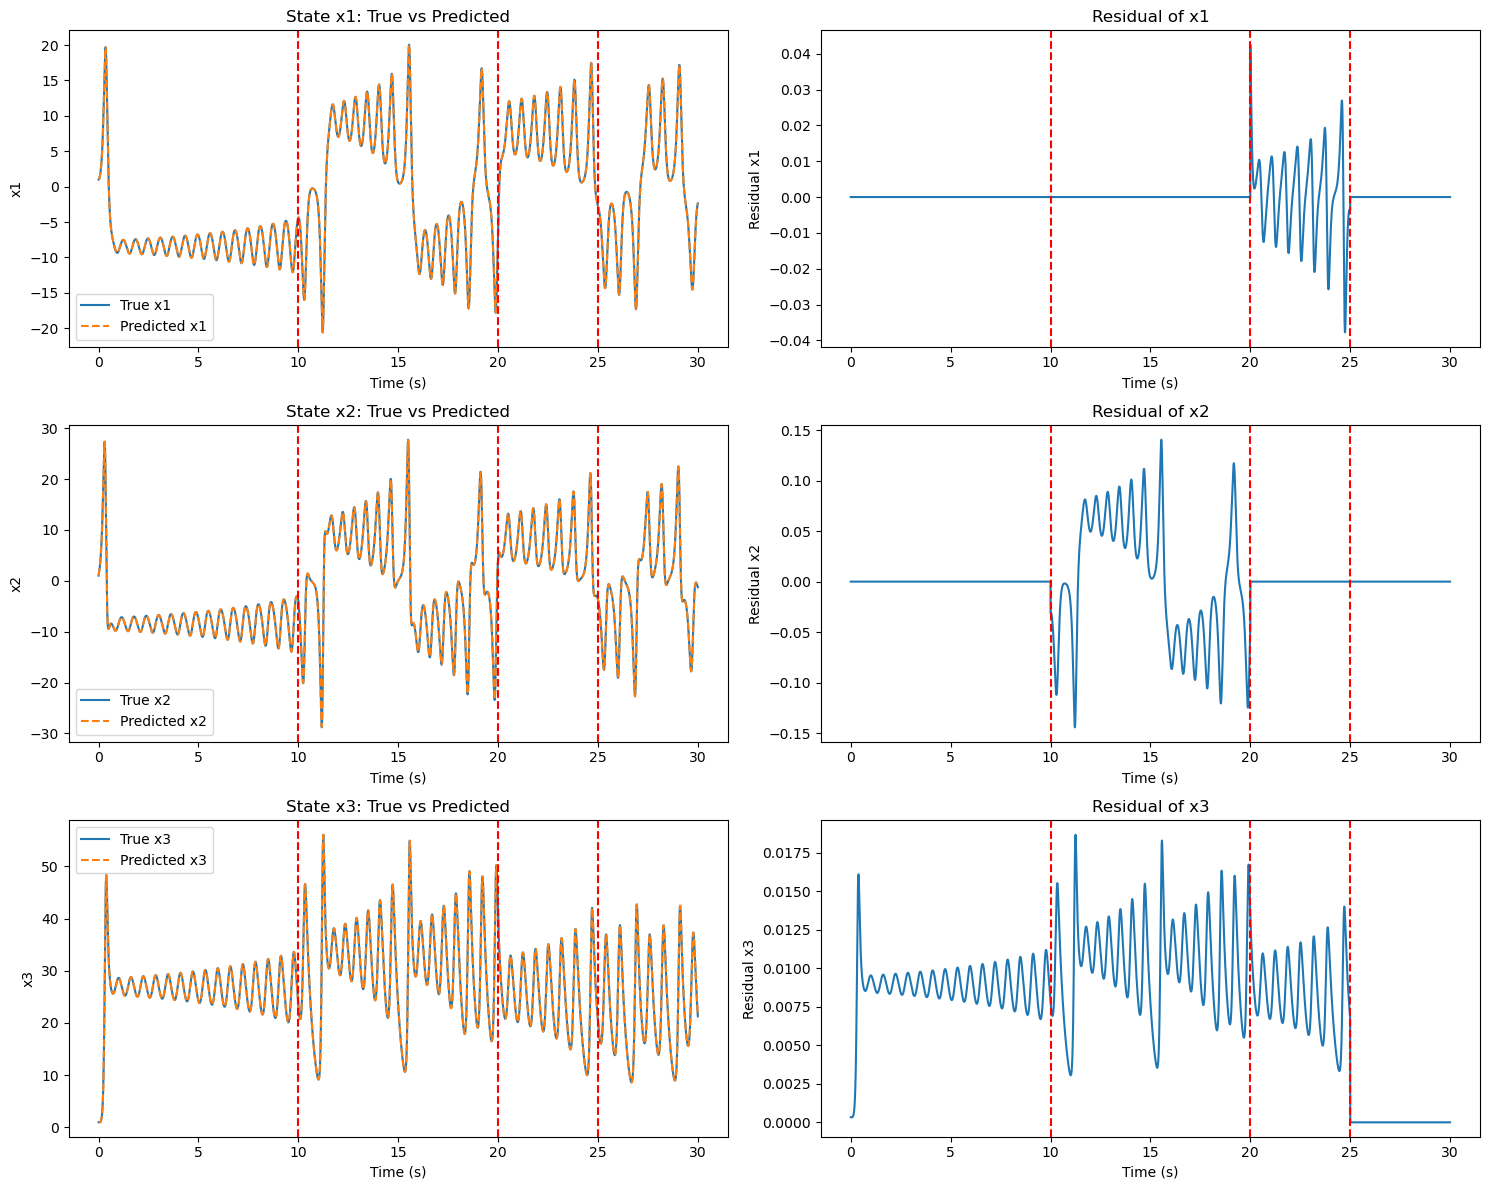

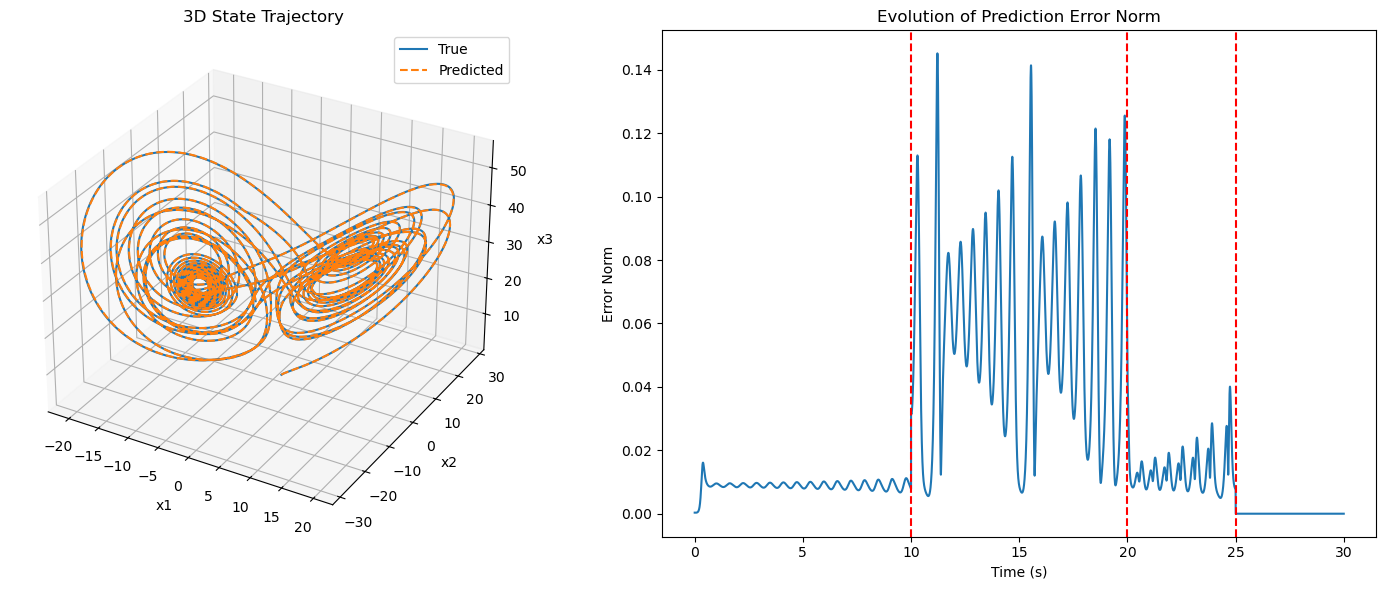

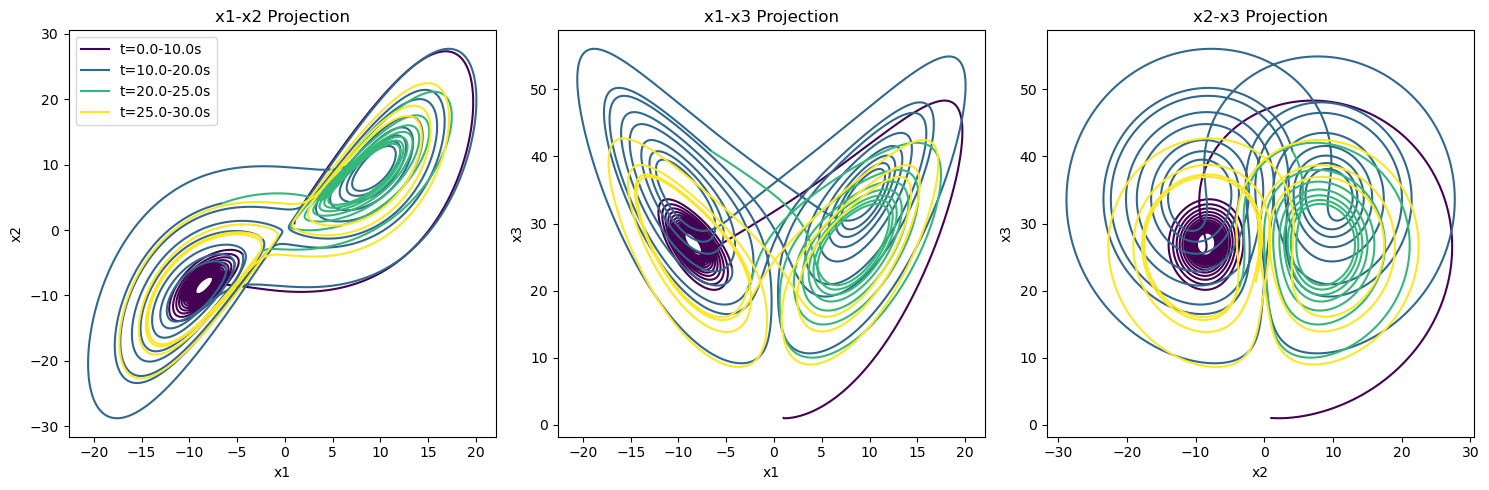

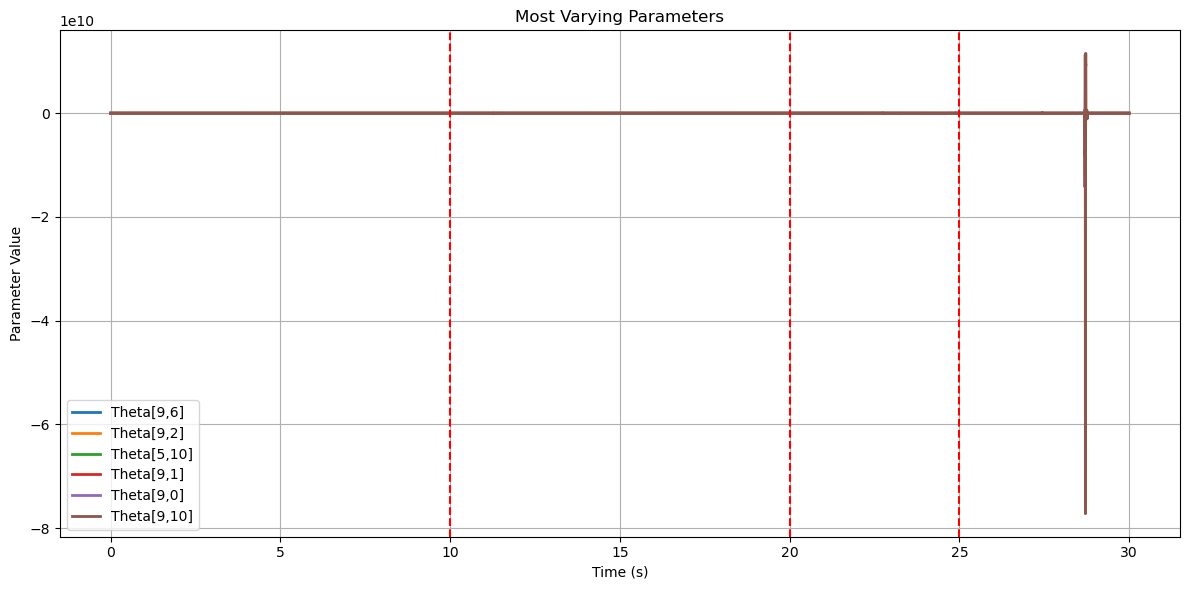


Performance Metrics for Each Stage:
--------------------------------------------------

Stage 1 (0s - 10.0s):
MAE: 0.002931
MSE: 0.000027

Stage 2 (10.0s - 20.0s):
MAE: 0.021942
MSE: 0.001416

Stage 3 (20.0s - 25.0s):
MAE: 0.006003
MSE: 0.000075

Stage 4 (25.0s - 30s):
MAE: 0.000001
MSE: 0.000000


In [9]:
# 保持导入库和基类定义不变...

# 定义 Lorenz 系统的动力学函数
def lorenz_system(x, u, sigma, rho, beta):
    x1, x2, x3 = x.flatten()
    dx1 = sigma * (x2 - x1)
    dx2 = x1 * (rho - x3) - x2 + u
    dx3 = x1 * x2 - beta * x3
    dx = np.array([dx1, dx2, dx3]).reshape(-1, 1)
    return dx

# 设置时间参数
dt = 0.001  # 更小的时间步长以保证数值稳定性
T = 30
N = int(T / dt)
time = np.linspace(0, T, N)

# 初始系统参数 (经典Lorenz参数)
sigma_1, rho_1, beta_1 = 10.0, 28.0, 8/3

# 系统变化后的参数
sigma_2, rho_2, beta_2 = 10.0, 35.0, 8/3    # 增大rho导致更剧烈的混沌
sigma_3, rho_3, beta_3 = 14.0, 28.0, 8/3    # 改变sigma影响同步特性
sigma_4, rho_4, beta_4 = 10.0, 28.0, 3.0    # 改变beta影响耗散特性

# 系统变化的时间点
change_times = [10.0, 20.0, 25.0]

# 控制输入（周期性外部扰动）
forcing_freq = 0.5
forcing_amp = 0.1
u = forcing_amp * np.sin(forcing_freq * time)

# 初始化状态数组
x = np.zeros((N, 3))
x[0, :] = [1.0, 1.0, 1.0]  # 初始条件

# 数据生成循环
for k in range(N - 1):
    x_k = x[k, :].reshape(-1, 1)
    u_k = u[k]
    t_k = time[k]
    
    if t_k < change_times[0]:
        sigma, rho, beta = sigma_1, rho_1, beta_1
    elif t_k < change_times[1]:
        sigma, rho, beta = sigma_2, rho_2, beta_2
    elif t_k < change_times[2]:
        sigma, rho, beta = sigma_3, rho_3, beta_3
    else:
        sigma, rho, beta = sigma_4, rho_4, beta_4
        
    dx = lorenz_system(x_k, u_k, sigma, rho, beta)
    x[k + 1, :] = (x_k + dx * dt).flatten()

# 定义升维函数
def lift_state(x):
    x1, x2, x3 = x.flatten()
    # 为Lorenz系统选择合适的基函数
    psi_x = np.array([
        x1,                  # 线性项
        x2,
        x3,
        x1*x2,              # 二次项（包含耦合项）
        x1*x3,
        x2*x3,
        x1**2,
        x2**2,
        x3**2,
        x1*x2*x3,          # 三次项
    ]).reshape(-1, 1)
    return psi_x

class CustomrEDMDc(rEDMDc):
    def _lift_state(self, x):
        return lift_state(x)

# 初始化模型
n_states = 3              # Lorenz系统是三维的
n_controls = 1
n_observables = 10        # 升维后的观测量维数

model = CustomrEDMDc(
    n_states=n_states,
    n_controls=n_controls,
    n_observables=n_observables,
    lambda_reg=1000.0,
    forgetting_factor=0.97  # 降低遗忘因子以更好地追踪混沌系统
)

# 拟合模型并进行预测
model.fit(x, u=u)
Theta_hist = np.array(model.Theta_hist_)

# 绘制参数矩阵的演化（使用热力图）
plt.figure(figsize=(15, 3))
time_points = [0, 10, 20, 25, 30]
for i, t in enumerate(time_points):
    time_idx = np.argmin(np.abs(time[:-1] - t))
    plt.subplot(1, len(time_points), i+1)
    plt.imshow(Theta_hist[time_idx], cmap='RdBu', aspect='auto')
    plt.colorbar()
    plt.title(f't = {t}s')
plt.tight_layout()
plt.show()

# 使用模型进行预测
y_pred = model.predict(x[:-1, :], u=u[:-1])
x_true = x[1:, :]

# 计算性能指标
MAE = np.mean(np.abs(x_true - y_pred))
MSE = np.mean((x_true - y_pred)**2)
print(f'MAE: {MAE}')
print(f'MSE: {MSE}')

# 绘制三维状态轨迹
from mpl_toolkits.mplot3d import Axes3D

# 计算残差和误差范数
residuals = x_true - y_pred
error_norm = np.linalg.norm(residuals, axis=1)

# 1. 绘制参数矩阵热力图演化
plt.figure(figsize=(15, 3))
time_points = [0, 10, 20, 25, 30]
for i, t in enumerate(time_points):
    time_idx = np.argmin(np.abs(time[:-1] - t))
    plt.subplot(1, len(time_points), i+1)
    plt.imshow(Theta_hist[time_idx], cmap='RdBu', aspect='auto')
    plt.colorbar()
    plt.title(f't = {t}s')
plt.tight_layout()
plt.show()

# 2. 绘制状态轨迹和残差分析（3×2布局）
plt.figure(figsize=(15, 12))

# x1分析
plt.subplot(321)
plt.plot(time[1:], x_true[:, 0], label='True x1')
plt.plot(time[1:], y_pred[:, 0], '--', label='Predicted x1')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('x1')
plt.legend()
plt.title('State x1: True vs Predicted')

plt.subplot(322)
plt.plot(time[1:], residuals[:, 0], label='x1 Residual')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Residual x1')
plt.title('Residual of x1')

# x2分析
plt.subplot(323)
plt.plot(time[1:], x_true[:, 1], label='True x2')
plt.plot(time[1:], y_pred[:, 1], '--', label='Predicted x2')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('x2')
plt.legend()
plt.title('State x2: True vs Predicted')

plt.subplot(324)
plt.plot(time[1:], residuals[:, 1], label='x2 Residual')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Residual x2')
plt.title('Residual of x2')

# x3分析
plt.subplot(325)
plt.plot(time[1:], x_true[:, 2], label='True x3')
plt.plot(time[1:], y_pred[:, 2], '--', label='Predicted x3')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('x3')
plt.legend()
plt.title('State x3: True vs Predicted')

plt.subplot(326)
plt.plot(time[1:], residuals[:, 2], label='x3 Residual')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Residual x3')
plt.title('Residual of x3')

plt.tight_layout()
plt.show()

# 3. 三维轨迹和误差范数
plt.figure(figsize=(15, 6))

# 3D轨迹
ax = plt.subplot(121, projection='3d')
ax.plot(x_true[:, 0], x_true[:, 1], x_true[:, 2], label='True')
ax.plot(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], '--', label='Predicted')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.legend()
ax.set_title('3D State Trajectory')

# 误差范数
plt.subplot(122)
plt.plot(time[1:], error_norm)
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Error Norm')
plt.title('Evolution of Prediction Error Norm')

plt.tight_layout()
plt.show()

# 4. 相空间投影（带时间颜色编码）
plt.figure(figsize=(15, 5))
stages = [(0, change_times[0]), 
         (change_times[0], change_times[1]),
         (change_times[1], change_times[2]),
         (change_times[2], T)]
colors = plt.cm.viridis(np.linspace(0, 1, len(stages)))

# x1-x2投影
plt.subplot(131)
for i, ((t_start, t_end), color) in enumerate(zip(stages, colors)):
    mask = (time[1:] >= t_start) & (time[1:] < t_end)
    plt.plot(x_true[mask, 0], x_true[mask, 1], color=color,
             label=f't={t_start:.1f}-{t_end:.1f}s')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('x1-x2 Projection')
plt.legend()

# x1-x3投影
plt.subplot(132)
for i, ((t_start, t_end), color) in enumerate(zip(stages, colors)):
    mask = (time[1:] >= t_start) & (time[1:] < t_end)
    plt.plot(x_true[mask, 0], x_true[mask, 2], color=color)
plt.xlabel('x1')
plt.ylabel('x3')
plt.title('x1-x3 Projection')

# x2-x3投影
plt.subplot(133)
for i, ((t_start, t_end), color) in enumerate(zip(stages, colors)):
    mask = (time[1:] >= t_start) & (time[1:] < t_end)
    plt.plot(x_true[mask, 1], x_true[mask, 2], color=color)
plt.xlabel('x2')
plt.ylabel('x3')
plt.title('x2-x3 Projection')

plt.tight_layout()
plt.show()

# 5. 参数变化分析
plt.figure(figsize=(12, 6))
param_std = np.std(Theta_hist, axis=0)
top_n = 6
flat_idx = np.argsort(param_std.flatten())[-top_n:]
i_idx, j_idx = np.unravel_index(flat_idx, param_std.shape)

for idx in range(top_n):
    i, j = i_idx[idx], j_idx[idx]
    plt.plot(time[:-1], Theta_hist[:, i, j], 
             label=f'Theta[{i},{j}]', linewidth=2)

for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Parameter Value')
plt.title('Most Varying Parameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. 计算各阶段性能指标
print("\nPerformance Metrics for Each Stage:")
print("-" * 50)
for i, (t_start, t_end) in enumerate(stages):
    mask = (time[1:] >= t_start) & (time[1:] < t_end)
    stage_MAE = np.mean(np.abs(residuals[mask]))
    stage_MSE = np.mean(residuals[mask]**2)
    print(f"\nStage {i+1} ({t_start}s - {t_end}s):")
    print(f"MAE: {stage_MAE:.6f}")
    print(f"MSE: {stage_MSE:.6f}")

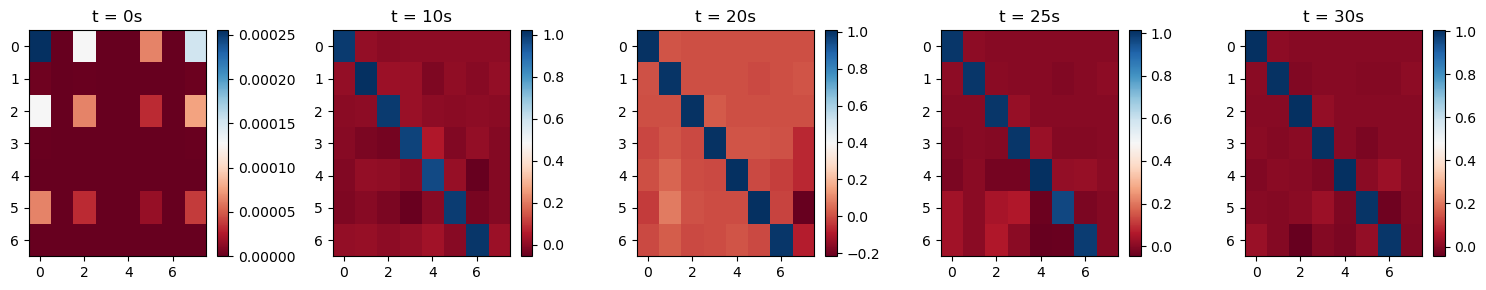

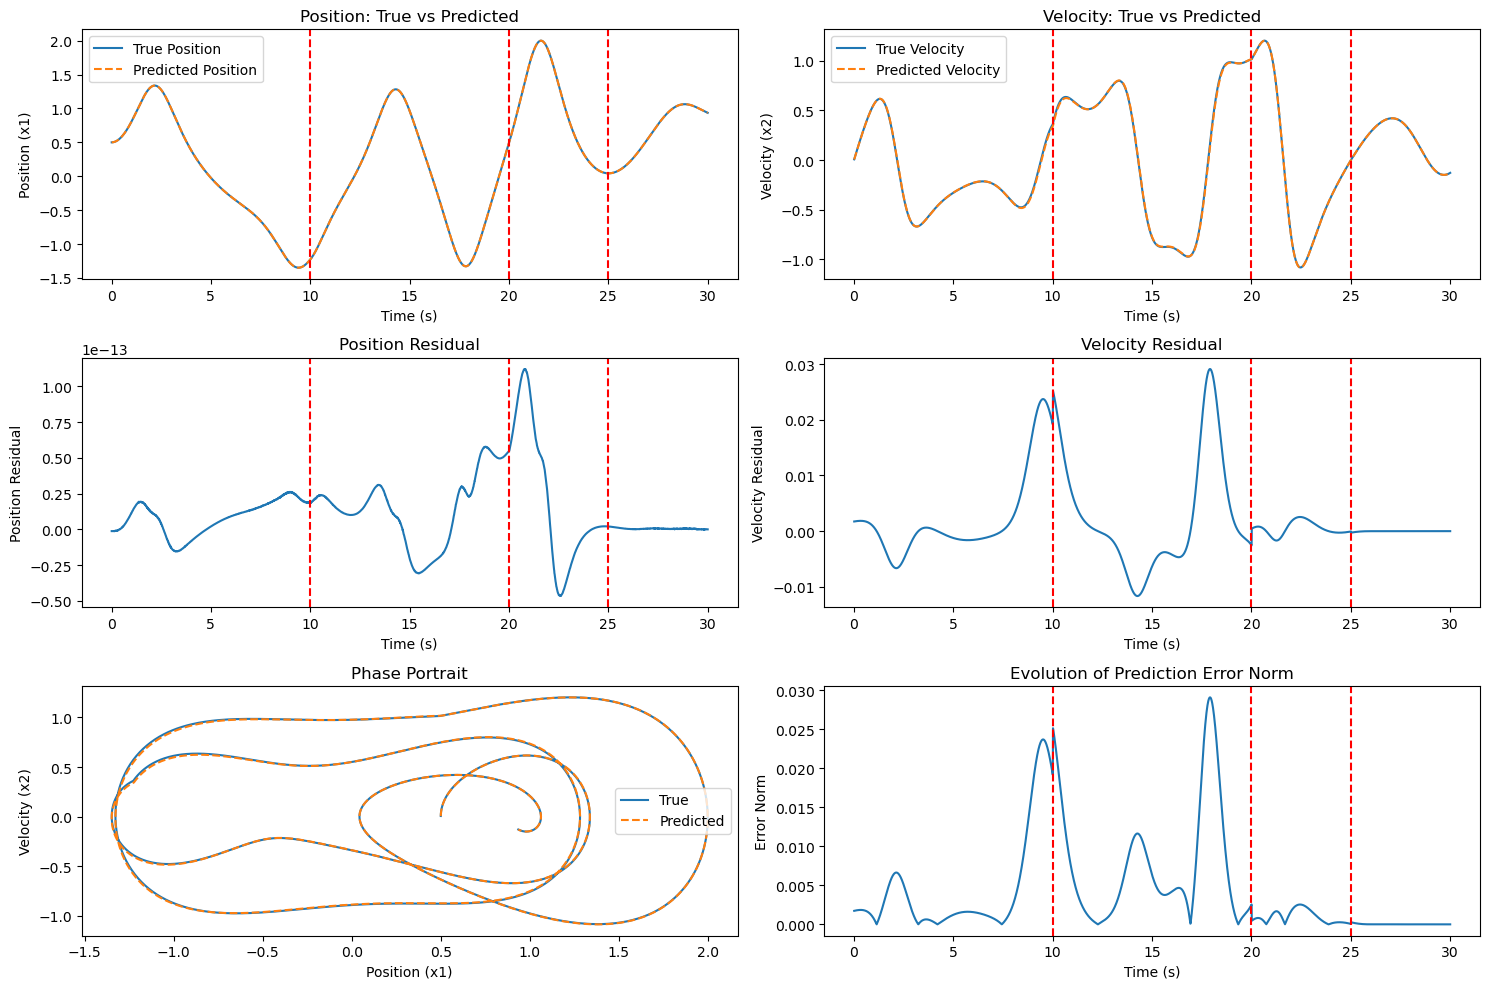

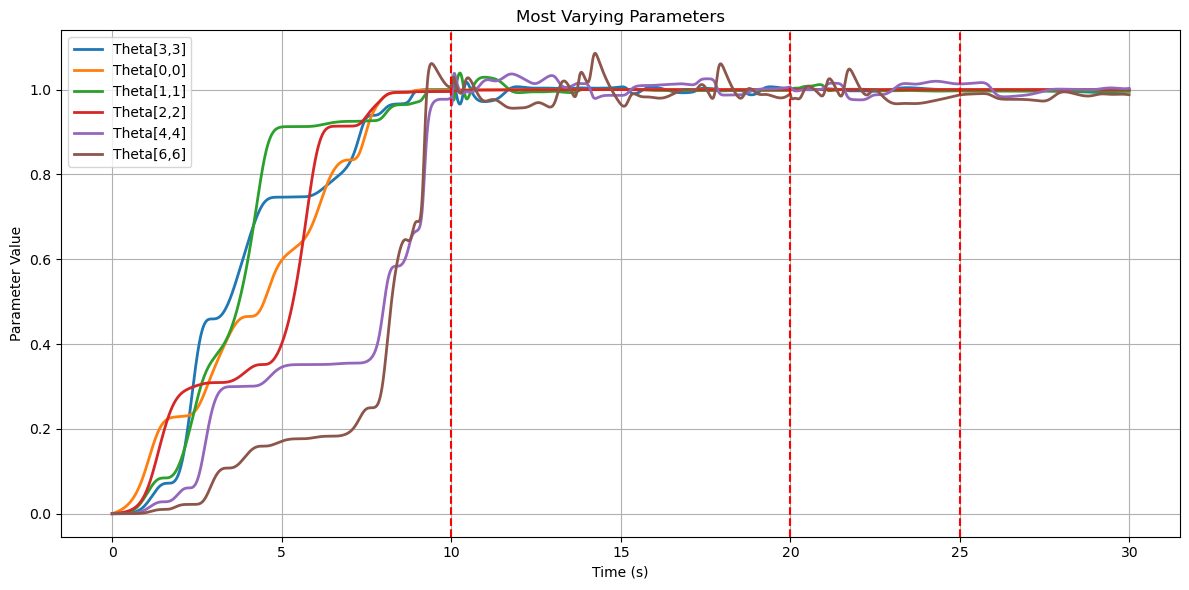


Performance Metrics for Each Stage:
--------------------------------------------------

Stage 1 (0s - 10.0s):
MAE: 0.002236
MSE: 0.000032

Stage 2 (10.0s - 20.0s):
MAE: 0.003842
MSE: 0.000059

Stage 3 (20.0s - 25.0s):
MAE: 0.000489
MSE: 0.000001

Stage 4 (25.0s - 30s):
MAE: 0.000010
MSE: 0.000000


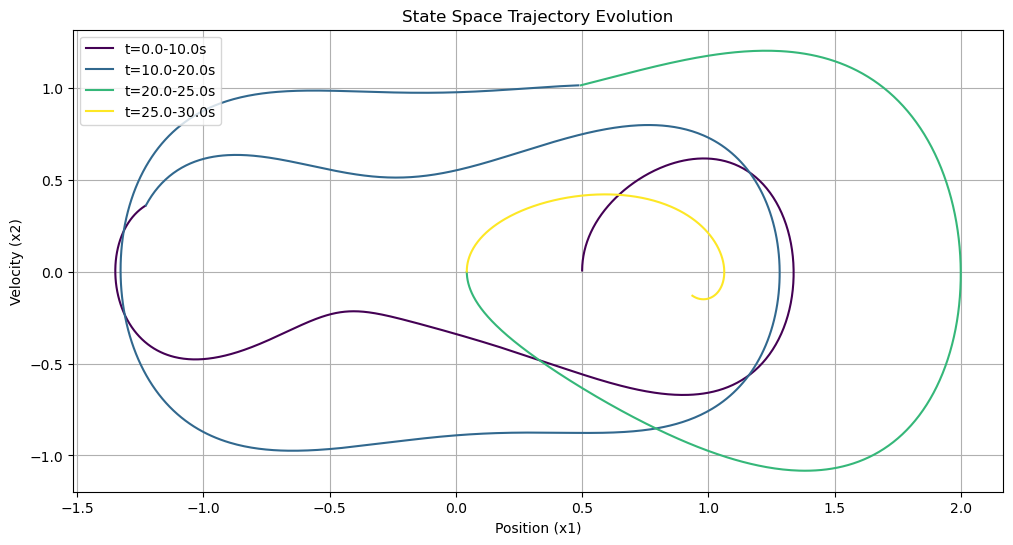

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_is_fitted
import time
from abc import ABC, abstractmethod
from sklearn.base import BaseEstimator

# 基础回归器类
class BaseRegressor(BaseEstimator, ABC):
    @abstractmethod
    def fit(self, x, y=None):
        pass

    @abstractmethod
    def predict(self, x):
        pass

    @property
    @abstractmethod
    def coef_(self):
        pass

# rEDMDc 类
class rEDMDc(BaseRegressor):
    def __init__(self, n_states, n_controls, n_observables, lambda_reg=1.0, forgetting_factor=1.0):
        self.n_states = n_states
        self.n_controls = n_controls
        self.n_observables = n_observables
        self.lambda_reg = lambda_reg
        self.forgetting_factor = forgetting_factor
        self.is_fitted_ = False

    def _initialize(self):
        self.Theta_ = np.zeros((self.n_observables, self.n_observables + self.n_controls))
        self.P_ = np.eye(self.n_observables + self.n_controls) / self.lambda_reg
        self.Theta_hist_ = []

    def _lift_state(self, x):
        pass  # 在子类中实现

    def fit(self, x, y=None, u=None):
        self._initialize()
        n_samples = x.shape[0]
        if u.ndim == 2 and u.shape[1] == 1:
            u = u.flatten()
        for k in range(n_samples - 1):
            x_k = x[k, :].reshape(-1, 1)
            x_k1 = x[k + 1, :].reshape(-1, 1)
            u_k = u[k]
            psi_x_k = self._lift_state(x_k)
            psi_x_k1 = self._lift_state(x_k1)
            phi_k = np.vstack([psi_x_k, [[u_k]]])
            e_k = psi_x_k1 - self.Theta_ @ phi_k
            denominator = self.forgetting_factor + phi_k.T @ self.P_ @ phi_k
            K_k = (self.P_ @ phi_k) / denominator
            self.Theta_ = self.Theta_ + e_k @ K_k.T
            self.Theta_hist_.append(self.Theta_.copy())
            self.P_ = (self.P_ - K_k @ phi_k.T @ self.P_) / self.forgetting_factor
        self.state_matrix_ = self.Theta_[:, :self.n_observables]
        self.control_matrix_ = self.Theta_[:, self.n_observables:]
        self.is_fitted_ = True
        return self

    def predict(self, x, u):
        check_is_fitted(self, "is_fitted_")
        n_samples = x.shape[0]
        y_pred = np.zeros((n_samples, self.n_states))
        if u.ndim == 2 and u.shape[1] == 1:
            u = u.flatten()
        for k in range(n_samples):
            x_k = x[k, :].reshape(-1, 1)
            u_k = u[k]
            psi_x_k = self._lift_state(x_k)
            phi_k = np.vstack([psi_x_k, [[u_k]]])
            psi_x_k1 = self.Theta_ @ phi_k
            y_pred[k, :] = psi_x_k1[:self.n_states].flatten()
        return y_pred

    @property
    def coef_(self):
        check_is_fitted(self, "Theta_")
        return self.Theta_

# 设置随机种子和时间参数
np.random.seed(42)
dt = 0.01
T = 30
N = int(T / dt)
time = np.linspace(0, T, N)

# 定义 Duffing 振子的系统动力学函数
def duffing_system(x, u, delta, alpha, beta):
    x1, x2 = x.flatten()
    dx1 = x2
    dx2 = -delta * x2 - alpha * x1 - beta * x1**3 + u
    dx = np.array([dx1, dx2]).reshape(-1, 1)
    return dx

# 初始系统参数
delta_1, alpha_1, beta_1 = 0.2, -1.0, 1.0

# 系统变化后的参数
delta_2, alpha_2, beta_2 = 0.2, -0.5, 1.0
delta_3, alpha_3, beta_3 = 0.2, -1.0, 0.5
delta_4, alpha_4, beta_4 = 0.2, -0.5, 0.5

# 系统变化的时间点
change_times = [10.0, 20.0, 25.0]

# 控制输入（周期驱动力）
omega = 1.0
gamma = 0.3
u = gamma * np.cos(omega * time)

# 初始化状态数组
x = np.zeros((N, 2))
x[0, :] = [0.5, 0.0]

# 数据生成循环
for k in range(N - 1):
    x_k = x[k, :].reshape(-1, 1)
    u_k = u[k]
    t_k = time[k]
    
    if t_k < change_times[0]:
        delta, alpha, beta = delta_1, alpha_1, beta_1
    elif t_k < change_times[1]:
        delta, alpha, beta = delta_2, alpha_2, beta_2
    elif t_k < change_times[2]:
        delta, alpha, beta = delta_3, alpha_3, beta_3
    else:
        delta, alpha, beta = delta_4, alpha_4, beta_4
        
    dx = duffing_system(x_k, u_k, delta, alpha, beta)
    x[k + 1, :] = (x_k + dx * dt).flatten()

# 定义升维函数
def lift_state(x):
    x1, x2 = x.flatten()
    psi_x = np.array([
        x1,                  # 线性项
        x2,
        x1**2,              # 二次项
        x1*x2,
        x2**2,
        x1**3,              # 三次项（Duffing系统的特征项）
        x2**3
    ]).reshape(-1, 1)
    return psi_x

# 自定义 rEDMDc 类
class CustomrEDMDc(rEDMDc):
    def _lift_state(self, x):
        return lift_state(x)

# 初始化和拟合模型
model = CustomrEDMDc(
    n_states=2,
    n_controls=1,
    n_observables=7,  # 修改为与升维函数输出维度匹配
    lambda_reg=1000.0,
    forgetting_factor=0.98
)

# 拟合模型
model.fit(x, u=u)

# 提取参数历史记录并进行预测
Theta_hist = np.array(model.Theta_hist_)
y_pred = model.predict(x[:-1, :], u=u[:-1])
x_true = x[1:, :]

# 计算残差和误差范数
residuals = x_true - y_pred
error_norm = np.linalg.norm(residuals, axis=1)

# 1. 绘制参数矩阵热力图演化
plt.figure(figsize=(15, 3))
time_points = [0, 10, 20, 25, 30]
for i, t in enumerate(time_points):
    time_idx = np.argmin(np.abs(time[:-1] - t))
    plt.subplot(1, len(time_points), i+1)
    plt.imshow(Theta_hist[time_idx], cmap='RdBu', aspect='auto')
    plt.colorbar()
    plt.title(f't = {t}s')
plt.tight_layout()
plt.show()

# 2. 绘制状态轨迹、残差和相图分析
plt.figure(figsize=(15, 10))

# 位置x1分析
plt.subplot(321)
plt.plot(time[1:], x_true[:, 0], label='True Position')
plt.plot(time[1:], y_pred[:, 0], '--', label='Predicted Position')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Position (x1)')
plt.legend()
plt.title('Position: True vs Predicted')

plt.subplot(323)
plt.plot(time[1:], residuals[:, 0], label='Position Residual')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Position Residual')
plt.title('Position Residual')

# 速度x2分析
plt.subplot(322)
plt.plot(time[1:], x_true[:, 1], label='True Velocity')
plt.plot(time[1:], y_pred[:, 1], '--', label='Predicted Velocity')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (x2)')
plt.legend()
plt.title('Velocity: True vs Predicted')

plt.subplot(324)
plt.plot(time[1:], residuals[:, 1], label='Velocity Residual')
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity Residual')
plt.title('Velocity Residual')

# 相图
plt.subplot(325)
plt.plot(x_true[:, 0], x_true[:, 1], label='True')
plt.plot(y_pred[:, 0], y_pred[:, 1], '--', label='Predicted')
plt.xlabel('Position (x1)')
plt.ylabel('Velocity (x2)')
plt.title('Phase Portrait')
plt.legend()

# 误差范数演化
plt.subplot(326)
plt.plot(time[1:], error_norm)
for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Error Norm')
plt.title('Evolution of Prediction Error Norm')

plt.tight_layout()
plt.show()

# 3. 绘制参数变化的关键部分
plt.figure(figsize=(12, 6))
param_std = np.std(Theta_hist, axis=0)
top_n = 6
flat_idx = np.argsort(param_std.flatten())[-top_n:]
i_idx, j_idx = np.unravel_index(flat_idx, param_std.shape)

for idx in range(top_n):
    i, j = i_idx[idx], j_idx[idx]
    plt.plot(time[:-1], Theta_hist[:, i, j], 
             label=f'Theta[{i},{j}]', linewidth=2)

for t in change_times:
    plt.axvline(x=t, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Parameter Value')
plt.title('Most Varying Parameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. 计算各阶段性能指标
stages = [(0, change_times[0]), 
          (change_times[0], change_times[1]),
          (change_times[1], change_times[2]),
          (change_times[2], T)]

print("\nPerformance Metrics for Each Stage:")
print("-" * 50)
for i, (t_start, t_end) in enumerate(stages):
    mask = (time[1:] >= t_start) & (time[1:] < t_end)
    MAE = np.mean(np.abs(residuals[mask]))
    MSE = np.mean(residuals[mask]**2)
    print(f"\nStage {i+1} ({t_start}s - {t_end}s):")
    print(f"MAE: {MAE:.6f}")
    print(f"MSE: {MSE:.6f}")

# 5. 绘制相空间轨迹的时间演化
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(change_times) + 1))
current_color = 0

for i, (t_start, t_end) in enumerate(stages):
    mask = (time[1:] >= t_start) & (time[1:] < t_end)
    plt.plot(x_true[mask, 0], x_true[mask, 1], 
             color=colors[current_color],
             label=f't={t_start:.1f}-{t_end:.1f}s')
    current_color += 1

plt.xlabel('Position (x1)')
plt.ylabel('Velocity (x2)')
plt.title('State Space Trajectory Evolution')
plt.legend()
plt.grid(True)
plt.show()

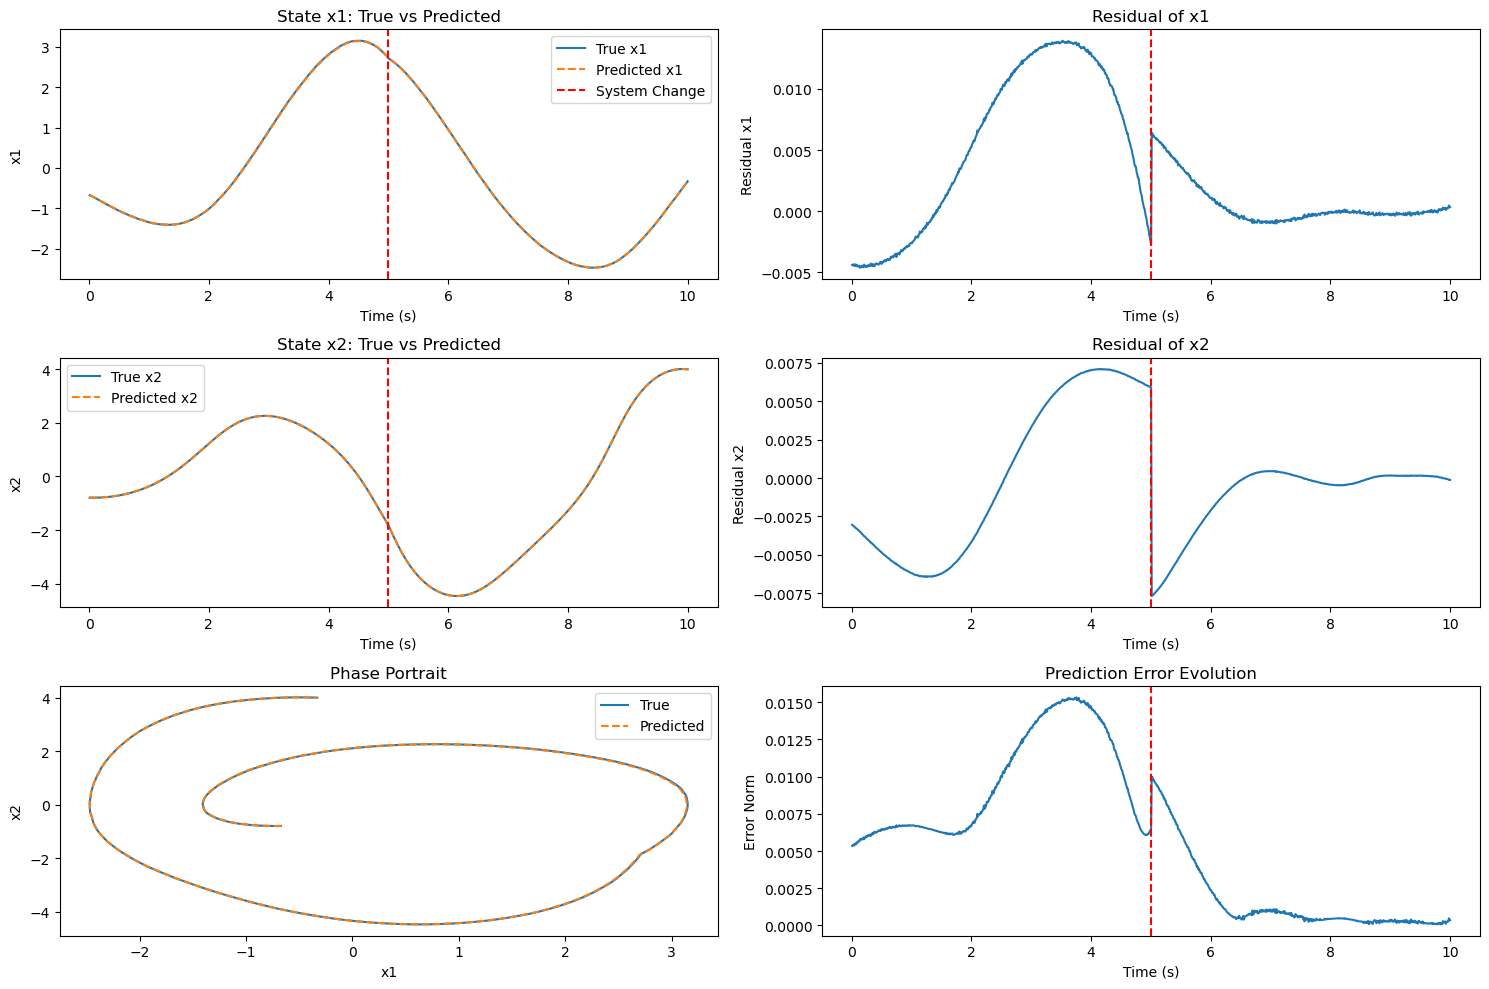

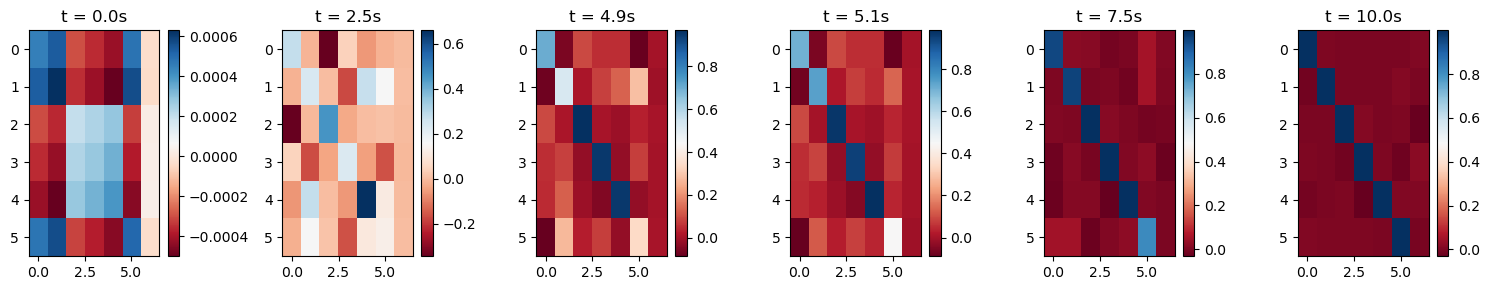

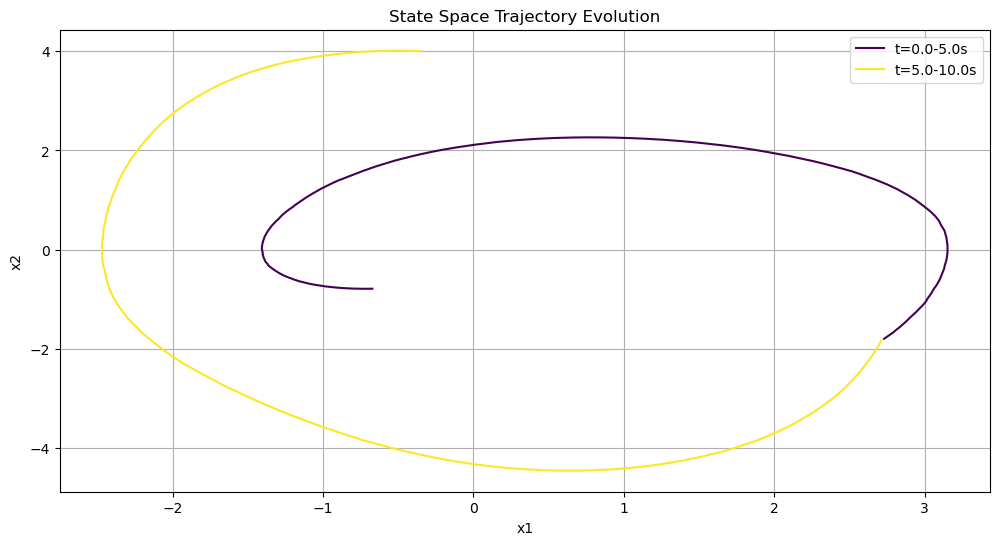

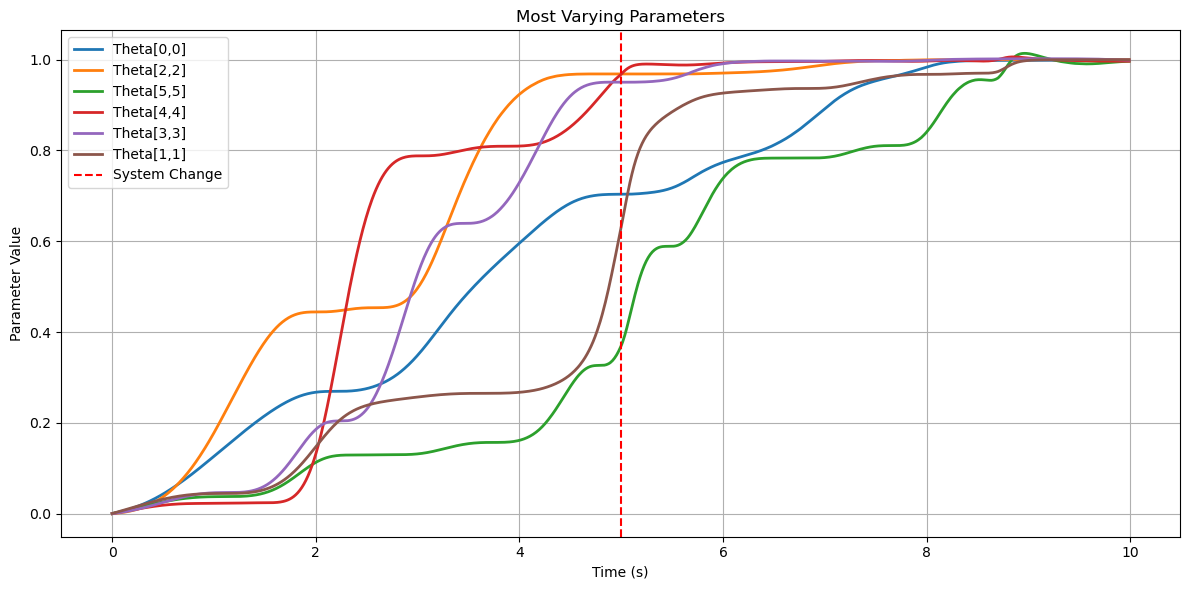


Performance Metrics:
--------------------------------------------------
Before System Change (t < 5s):
MAE: 0.006148
MSE: 0.000052

After System Change (t >= 5s):
MAE: 0.001139
MSE: 0.000005


In [11]:
# 设置随机种子和时间参数
np.random.seed(42)
dt = 0.01
T = 10
N = int(T / dt)
time = np.linspace(0, T, N)

# 初始化状态和控制输入
x = np.zeros((N, 2))
u = np.random.normal(0, 0.1, size=N)
x[0, :] = np.random.uniform(-1, 1, size=2)

# 系统变化时间点
change_time = 5.0

# 数据生成循环
for k in range(N - 1):
    x_k = x[k, :].reshape(-1, 1)
    u_k = u[k]
    if time[k] >= change_time:
        dx = system_dynamics(x_k, u_k, system_change=True)
    else:
        dx = system_dynamics(x_k, u_k, system_change=False)
    x[k + 1, :] = (x_k + dx * dt).flatten()

# 定义升维函数（针对这个二维系统）
def lift_state(x):
    x1, x2 = x.flatten()
    psi_x = np.array([
        x1,                  # 线性项
        x2,
        x1**2,              # 二次项
        x1*x2,
        x2**2,
        np.sin(x2)          # 非线性项
    ]).reshape(-1, 1)
    return psi_x

class CustomrEDMDc(rEDMDc):
    def _lift_state(self, x):
        return lift_state(x)

# 初始化和拟合模型
model = CustomrEDMDc(
    n_states=2,
    n_controls=1,
    n_observables=6,
    lambda_reg=1000.0,
    forgetting_factor=0.99
)

# 拟合模型并进行预测
model.fit(x, u=u)
Theta_hist = np.array(model.Theta_hist_)
y_pred = model.predict(x[:-1, :], u=u[:-1])
x_true = x[1:, :]

# 计算残差和误差范数
residuals = x_true - y_pred
error_norm = np.linalg.norm(residuals, axis=1)

# 1. 绘制系统动态和残差分析
plt.figure(figsize=(15, 10))

# x1分析
plt.subplot(321)
plt.plot(time[1:], x_true[:, 0], label='True x1')
plt.plot(time[1:], y_pred[:, 0], '--', label='Predicted x1')
plt.axvline(x=change_time, color='r', linestyle='--', label='System Change')
plt.xlabel('Time (s)')
plt.ylabel('x1')
plt.legend()
plt.title('State x1: True vs Predicted')

plt.subplot(322)
plt.plot(time[1:], residuals[:, 0])
plt.axvline(x=change_time, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Residual x1')
plt.title('Residual of x1')

# x2分析
plt.subplot(323)
plt.plot(time[1:], x_true[:, 1], label='True x2')
plt.plot(time[1:], y_pred[:, 1], '--', label='Predicted x2')
plt.axvline(x=change_time, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('x2')
plt.legend()
plt.title('State x2: True vs Predicted')

plt.subplot(324)
plt.plot(time[1:], residuals[:, 1])
plt.axvline(x=change_time, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Residual x2')
plt.title('Residual of x2')

# 相图和误差范数
plt.subplot(325)
plt.plot(x_true[:, 0], x_true[:, 1], label='True')
plt.plot(y_pred[:, 0], y_pred[:, 1], '--', label='Predicted')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Portrait')
plt.legend()

plt.subplot(326)
plt.plot(time[1:], error_norm)
plt.axvline(x=change_time, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Error Norm')
plt.title('Prediction Error Evolution')

plt.tight_layout()
plt.show()

# 2. 参数矩阵热力图演化
plt.figure(figsize=(15, 3))
time_points = [0, 2.5, 4.9, 5.1, 7.5, 10.0]
for i, t in enumerate(time_points):
    time_idx = np.argmin(np.abs(time[:-1] - t))
    plt.subplot(1, len(time_points), i+1)
    plt.imshow(Theta_hist[time_idx], cmap='RdBu', aspect='auto')
    plt.colorbar()
    plt.title(f't = {t:.1f}s')
plt.tight_layout()
plt.show()

# 3. 相空间轨迹的时间演化
plt.figure(figsize=(12, 6))
stages = [(0, change_time), (change_time, T)]
colors = plt.cm.viridis(np.linspace(0, 1, len(stages)))

for i, ((t_start, t_end), color) in enumerate(zip(stages, colors)):
    mask = (time[1:] >= t_start) & (time[1:] < t_end)
    plt.plot(x_true[mask, 0], x_true[mask, 1], 
             color=color, label=f't={t_start:.1f}-{t_end:.1f}s')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('State Space Trajectory Evolution')
plt.legend()
plt.grid(True)
plt.show()

# 4. 参数变化分析
plt.figure(figsize=(12, 6))
param_std = np.std(Theta_hist, axis=0)
top_n = 6
flat_idx = np.argsort(param_std.flatten())[-top_n:]
i_idx, j_idx = np.unravel_index(flat_idx, param_std.shape)

for idx in range(top_n):
    i, j = i_idx[idx], j_idx[idx]
    plt.plot(time[:-1], Theta_hist[:, i, j], 
             label=f'Theta[{i},{j}]', linewidth=2)

plt.axvline(x=change_time, color='r', linestyle='--', label='System Change')
plt.xlabel('Time (s)')
plt.ylabel('Parameter Value')
plt.title('Most Varying Parameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. 计算分段性能指标
mask_before = time[1:] < change_time
mask_after = time[1:] >= change_time

# 计算各阶段的性能指标
MAE_before = np.mean(np.abs(residuals[mask_before]))
MSE_before = np.mean(residuals[mask_before]**2)
MAE_after = np.mean(np.abs(residuals[mask_after]))
MSE_after = np.mean(residuals[mask_after]**2)

print("\nPerformance Metrics:")
print("-" * 50)
print("Before System Change (t < 5s):")
print(f"MAE: {MAE_before:.6f}")
print(f"MSE: {MSE_before:.6f}")
print("\nAfter System Change (t >= 5s):")
print(f"MAE: {MAE_after:.6f}")
print(f"MSE: {MSE_after:.6f}")

In [12]:
from graphviz import Digraph

# 创建有向图
dot = Digraph(comment='rEDMDc Algorithm Flow')
dot.attr(rankdir='TB')

# 设置节点样式
dot.attr('node', shape='box', style='rounded')

# 添加节点
dot.node('A', 'Initialize\nΘ = 0, P = λI')
dot.node('B', 'Input Data\nx(k), u(k)')
dot.node('C', 'State Lifting\nψ(x(k))')
dot.node('D', 'Form Regression Vector\nφ(k) = [ψ(x(k)); u(k)]')
dot.node('E', 'Predict Next State\nψ̂(x(k+1)) = Θ φ(k)')
dot.node('F', 'Compute Error\ne(k) = ψ(x(k+1)) - ψ̂(x(k+1))')
dot.node('G', 'Calculate Gain\nK(k) = P φ(k) / (λ + φ(k)ᵀ P φ(k))')
dot.node('H', 'Update Parameters\nΘ = Θ + e(k) K(k)ᵀ')
dot.node('I', 'Update Covariance\nP = (P - K(k) φ(k)ᵀ P) / λ')
dot.node('J', 'Extract Matrices\nA = Θ[:,:n]\nB = Θ[:,n:]')

# 添加边
dot.edge('A', 'B', 'Start')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('G', 'H')
dot.edge('H', 'I')
dot.edge('I', 'J')
dot.edge('J', 'B', 'Next Time Step')

# 保存图片
dot.render('redmdc_flow', format='png', cleanup=True)

'redmdc_flow.png'